# Modeling TF-IDF + XGB (XGBoostClassifier) Notebook

**Based on the developed pipeline in `template_logreg_tfidf.ipynb`**

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2
from xgboost import XGBClassifier
from sklearn.metrics import (
    fbeta_score,
    make_scorer
)
from joblib import dump, load
from scipy.stats import loguniform, randint

root_path = Path.cwd().parents[1]  #go to root
sys.path.append(str(root_path))
from src.evaluation_visualization import (
    plot_learning_curves,
    plot_confusion_matrix,
    plot_roc_and_pr_curves,
    plot_threshold_curves,
    extended_classification_report,
    get_metrics_dict,
    quick_f2_score_default_threshold
)
from src.preprocessing import process_file
from src.optimize_threshold import (
    optimize_threshold_with_cv,
    get_threshold_evaluation_data,
    get_threshold_evaluation_data_cv
)
from src.optuna_optimizer import (
    optimize_with_optuna_tpe,
    sample_class_weight_value,
    grid_search_with_optuna
)
from src.optuna_visualizations import (
    plot_optuna_study_analysis,
    quick_optuna_analysis
)

from src.phrase_transformer import PhraseDetector

c:\Users\tdoro\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**a) XGBClassifier with basic preprocessed data**

In [2]:
# Load and preprocess data (basic mode)
df_basiccleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='basic'  # basic cleaning mode
)

# Map labels to binary values
df_basiccleaned['Label'] = df_basiccleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

In [5]:
XGBClassifier?

Init signature:
XGBClassifier(
    *,
    objective: Union[str, xgboost.sklearn._SklObjWProto, Callable[[Any, Any], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic',
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost classification.
See :doc:`/python/sklearn_estimator` for more information.

Parameters
----------

    n_estimators : Optional[int]
        Number of boosting rounds.

    max_depth :  typing.Optional[int]

        Maximum tree depth for base learners.

    max_leaves : typing.Optional[int]

        Maximum number of leaves; 0 indicates no limit.

    max_bin : typing.Optional[int]

        If using histogram-based algorithm, maximum number of bins per feature

    grow_policy : typing.Optional[str]

        Tree growing policy.

        - depthwise: Favors splitting at nodes closest to the node,
        - lossguide: Favors splitting at nodes with highest loss change.

    learning_rate : typing.Optional[float

XGB TPE basic

Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(


Best parameters found by Optuna TPE: {'clf__learning_rate': 0.05182315450634667, 'clf__max_depth': 4, 'clf__gamma': 1.4540528143810914, 'clf__n_estimators': 2760, 'clf__colsample_bytree': 0.24131258605900507, 'clf__scale_pos_weight': 5.1778071031392665, 'clf__reg_alpha': 0.0027713398514566797, 'select__k': 133}
Best F2 score during optimization: 0.855

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


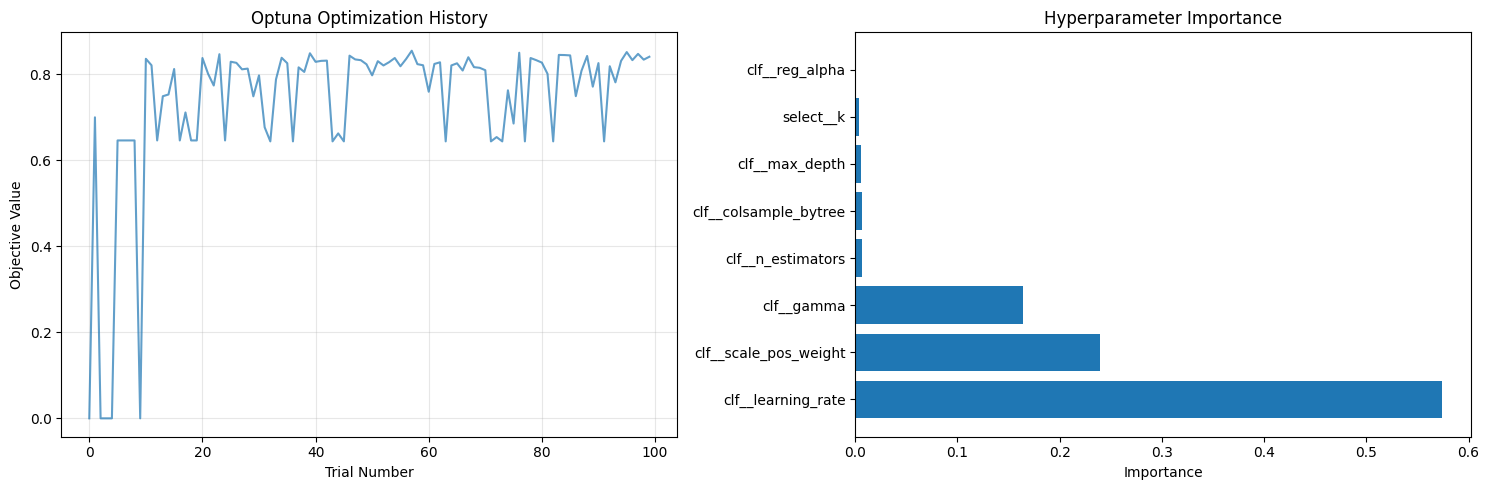


2. Parameter Value Distributions:


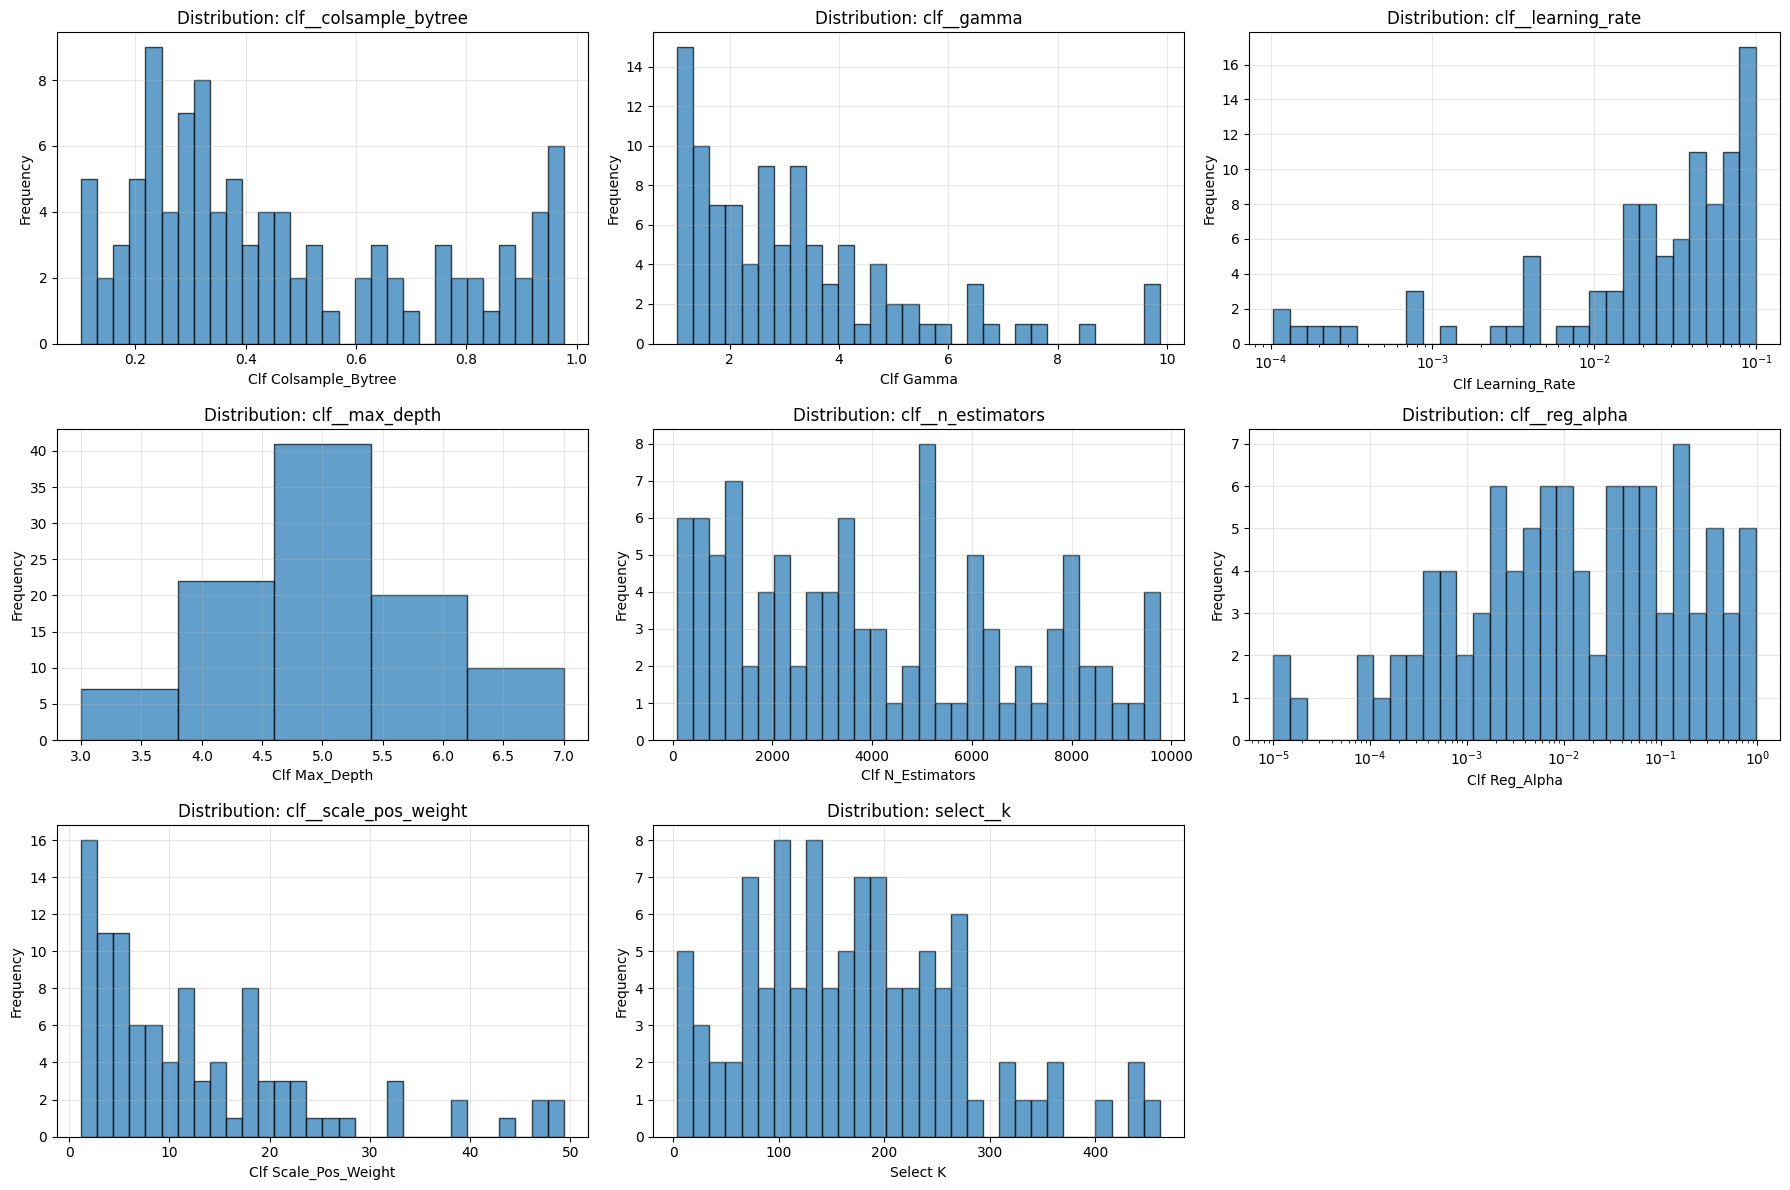


3. Performance vs Individual Parameters:


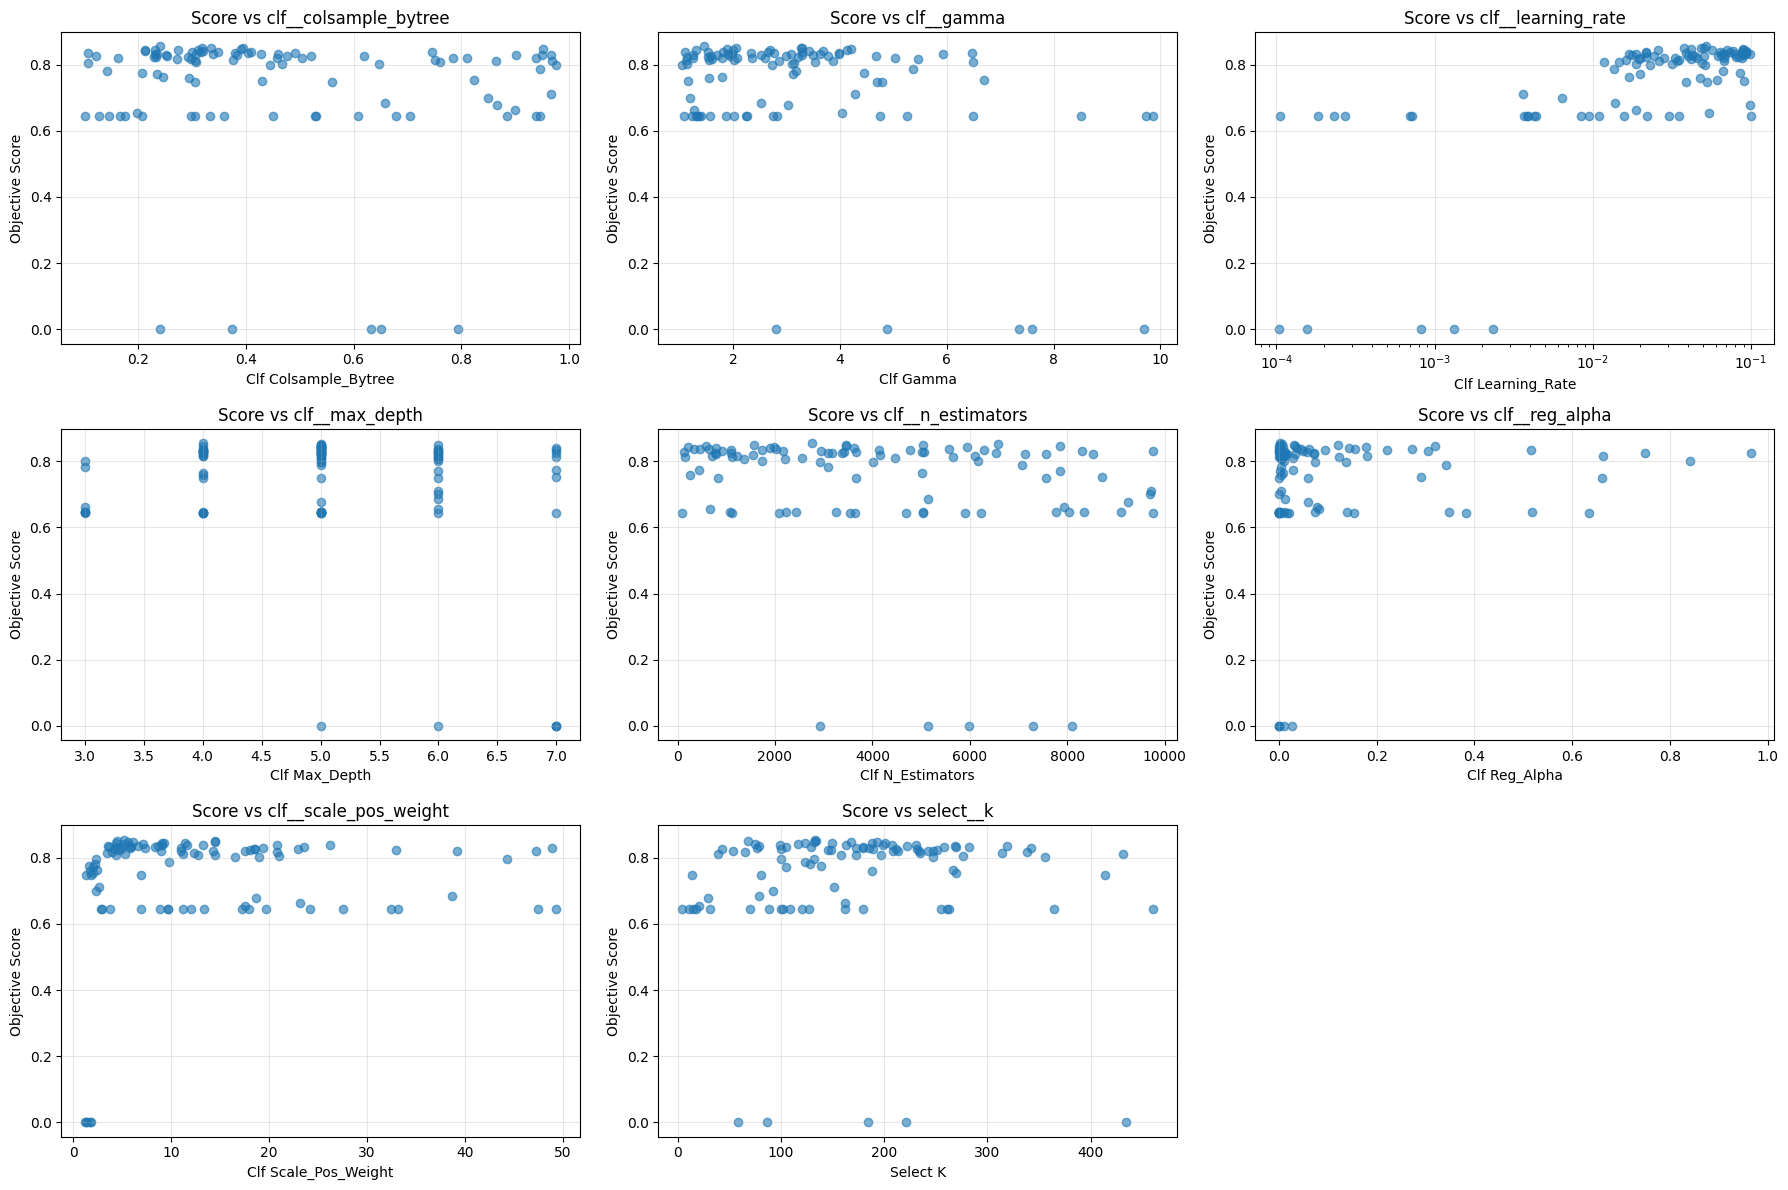


4. Convergence Analysis:


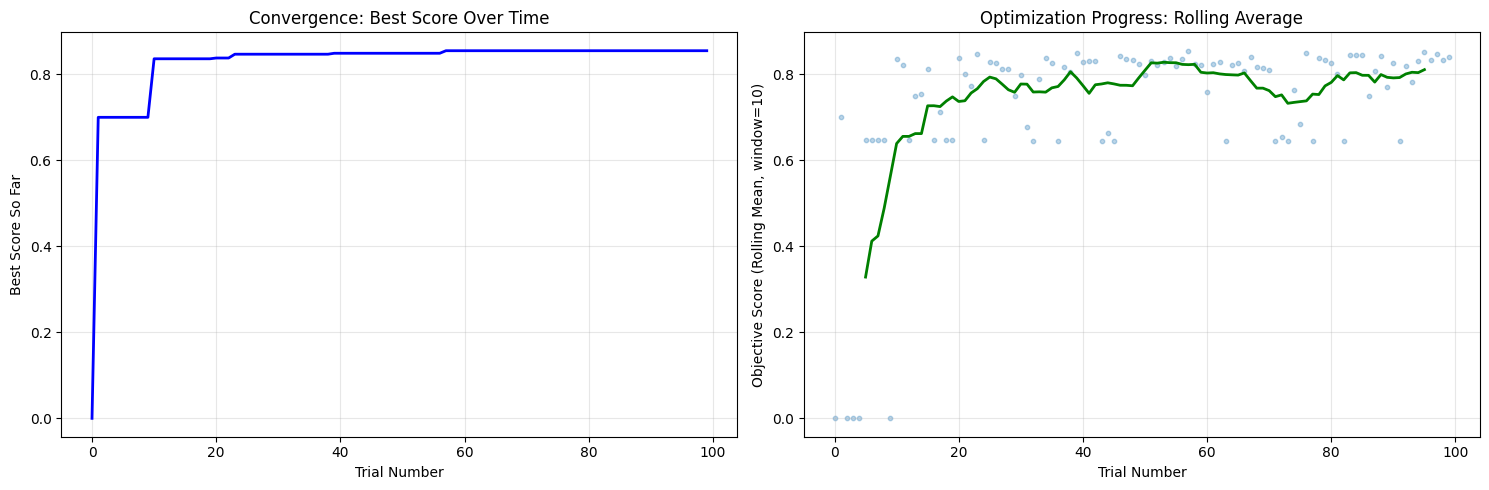


5. Trial Status Overview:


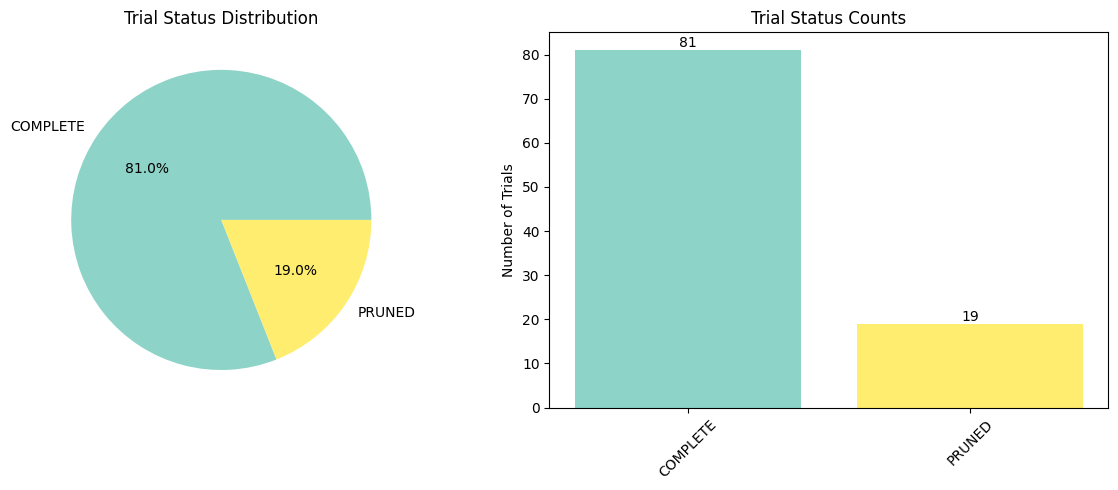


6. Top 10 Best Trials:
Rank Trial#  Score      colsample_bytree gamma        learning_rate max_depth    n_estimators reg_alpha    scale_pos_weight k           
----------------------------------------------------------------------------------------------------------------------------------------
1    57      0.8547     0.2413       1.4541       0.0518       4            2760         0.0028       5.1778       133         
2    95      0.8515     0.3350       3.2663       0.0508       5            6580         0.0055       4.4854       68          
3    76      0.8500     0.3943       3.2971       0.0484       5            1560         0.1199       14.4850      134         
4    39      0.8488     0.3185       2.0449       0.0380       5            3460         0.0298       5.6281       193         
5    97      0.8474     0.3917       4.2016       0.0899       6            5030         0.0028       6.1214       132         
6    23      0.8466     0.9507       1.8936       0.0420      

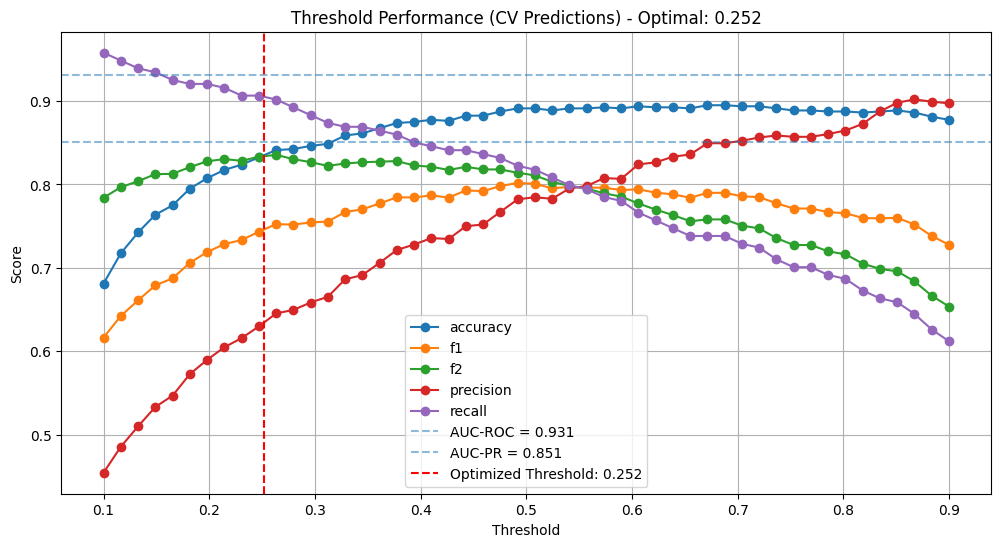

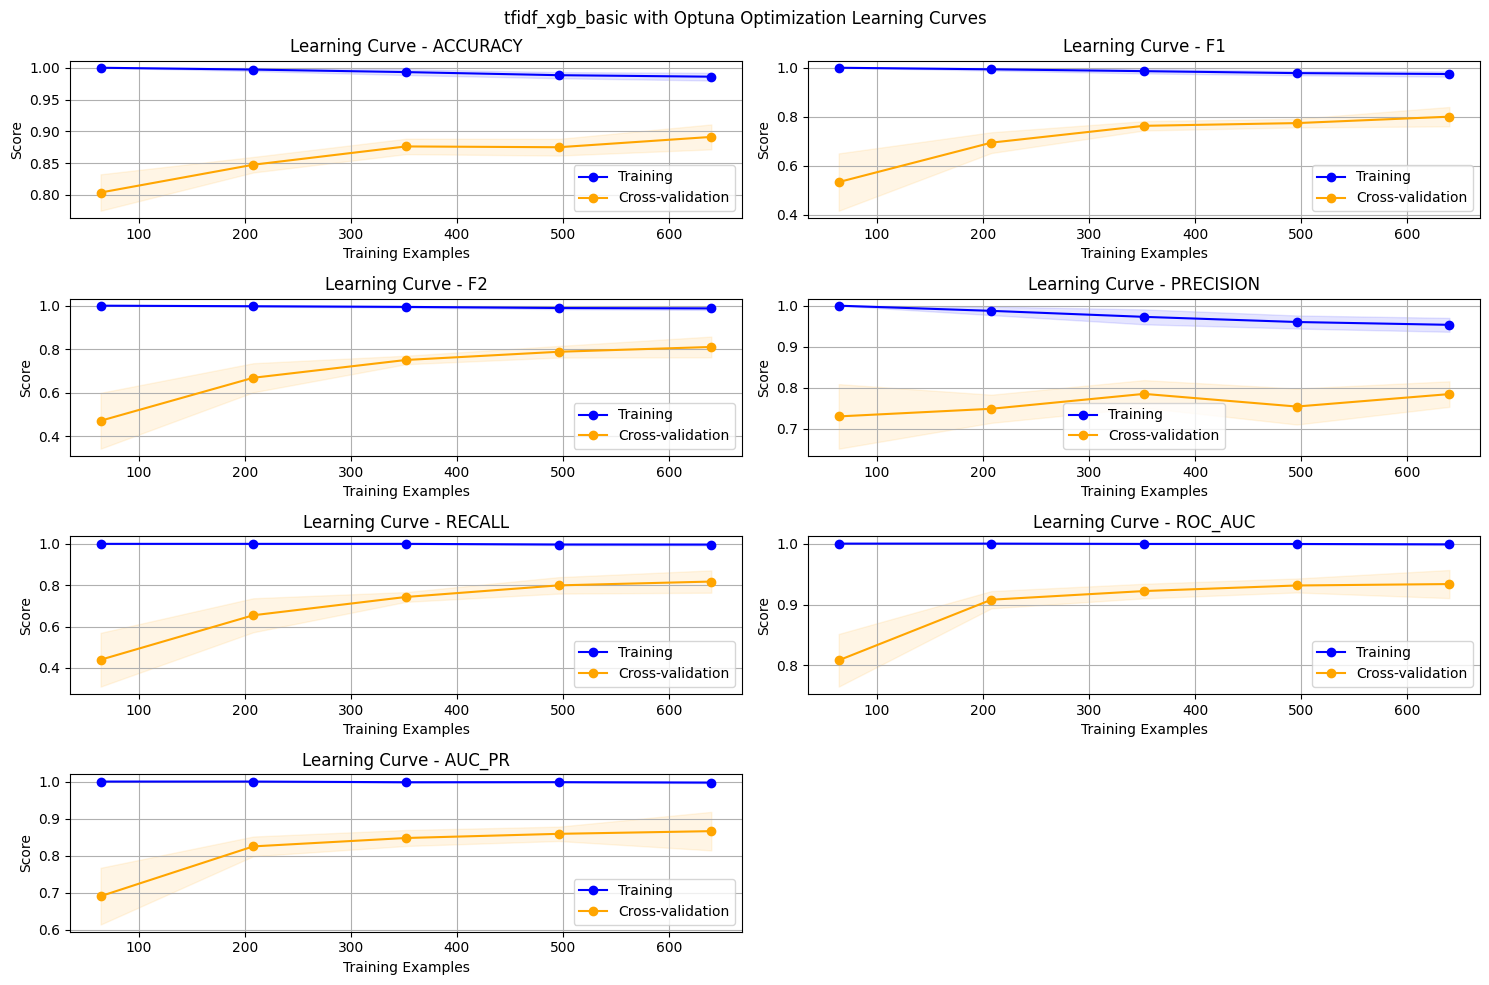


Final Threshold: 0.25

Test Set Performance:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       146
           1       0.62      0.83      0.71        54

    accuracy                           0.82       200
   macro avg       0.78      0.82      0.79       200
weighted avg       0.85      0.82      0.83       200

Additional Metrics:
Accuracy   0.820
F2-score   0.781
AUC-ROC    0.892
AUC-PR     0.813



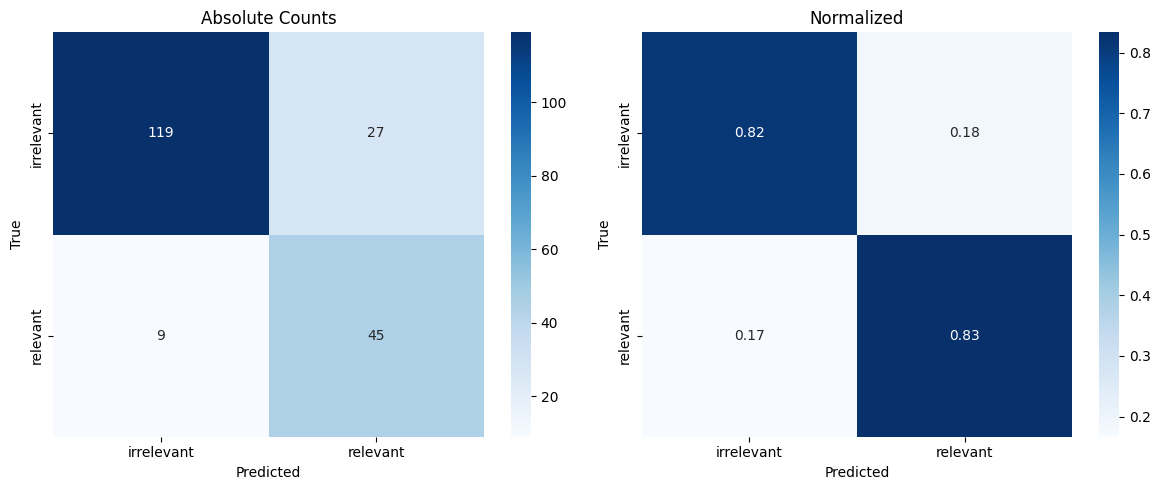

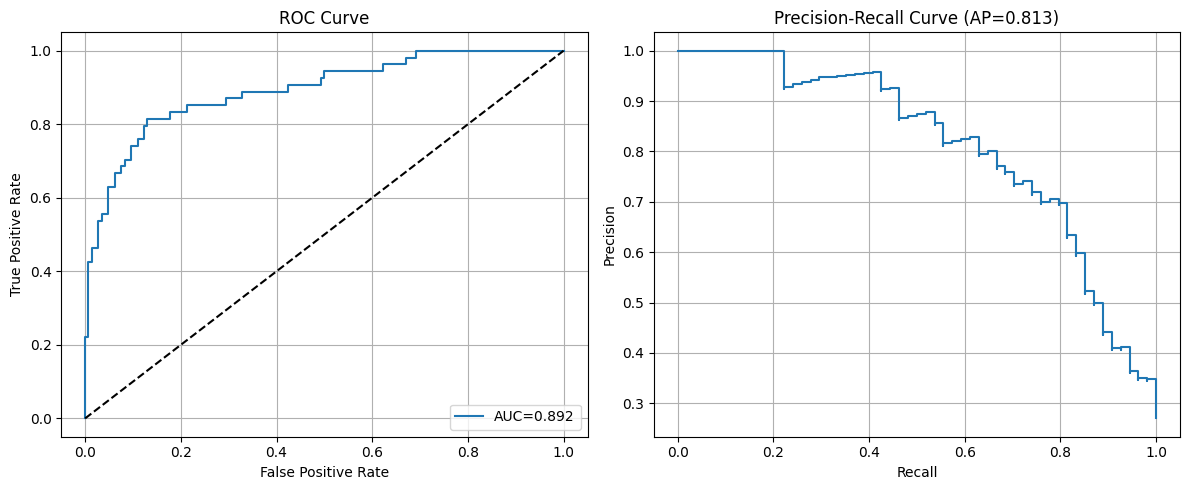


Model saved as model_tfidf_xgb_basic.joblib


In [3]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a XGB classifier 
pipeline_tfidf_xgb = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("clf",     XGBClassifier(
                objective='binary:logistic',
                tree_method='hist',
                n_jobs=-1,  # Use all available CPU cores
                random_state=42,                  
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
param_space = {
    "clf__learning_rate":    lambda t: t.suggest_float("clf__learning_rate", 1e-4, 1e-1, log=True),   #  Reusens et al. ranges; log-scale matches multiplicative sensitivity of LR
    "clf__max_depth":        lambda t: t.suggest_int("clf__max_depth", 3, 7),                         #  Reusens et al.: shallow trees fit high-dim sparse TF-IDF features
    "clf__gamma":            lambda t: t.suggest_float("clf__gamma", 1.0, 10.0),                      #  Reusens et al.: minimum loss reduction to make a split (regularizes splits)
    "clf__n_estimators":     lambda t: t.suggest_int("clf__n_estimators", 10, 10000, step=10),        #  Reusens et al.: upper bound; Early Stopping in  objective picks best iteration
    "clf__colsample_bytree": lambda t: t.suggest_float("clf__colsample_bytree", 0.1, 1.0),            #  Reusens et al.: feature subsampling per tree; helps generalization with many sparse features
    "clf__scale_pos_weight": lambda t: t.suggest_float("clf__scale_pos_weight", 1.0, 50.0, log=True), #  XGBoost-native class balancing; typical anchor is sum(neg)/sum(pos). Search narrowly (±~3x, log) around data-driven ratio.
    "clf__reg_alpha":        lambda t: t.suggest_float("clf__reg_alpha", 1e-5, 1.0, log=True),        # useful L1 on leaf weights: promotes conservatism/sparsity in tree outputs; kept narrow & log to avoid bloating search
    "select__k":             lambda t: t.suggest_int("select__k", 1, 500, step=1),                    # Consistent with  template; chi² directly controls dimensionality (requires non-negative features)
}

model_name = "tfidf_xgb_basic"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_tfidf_xgb,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    model_type = "xgboost",
    n_trials=100,  # Intelligent search with early stopping
    direction="maximize",
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name=model_name
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")

XGB GridSearch Basic

Starting Optuna hyperparameter optimization ...
Best parameters found by Optuna TPE: {'clf__learning_rate': 0.048, 'clf__scale_pos_weight': 14.0, 'clf__gamma': 2.5, 'clf__max_depth': 3, 'clf__n_estimators': 3500, 'clf__colsample_bytree': 0.241, 'clf__reg_alpha': 0.003, 'select__k': 133}
Best F2 score during optimization: 0.833

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


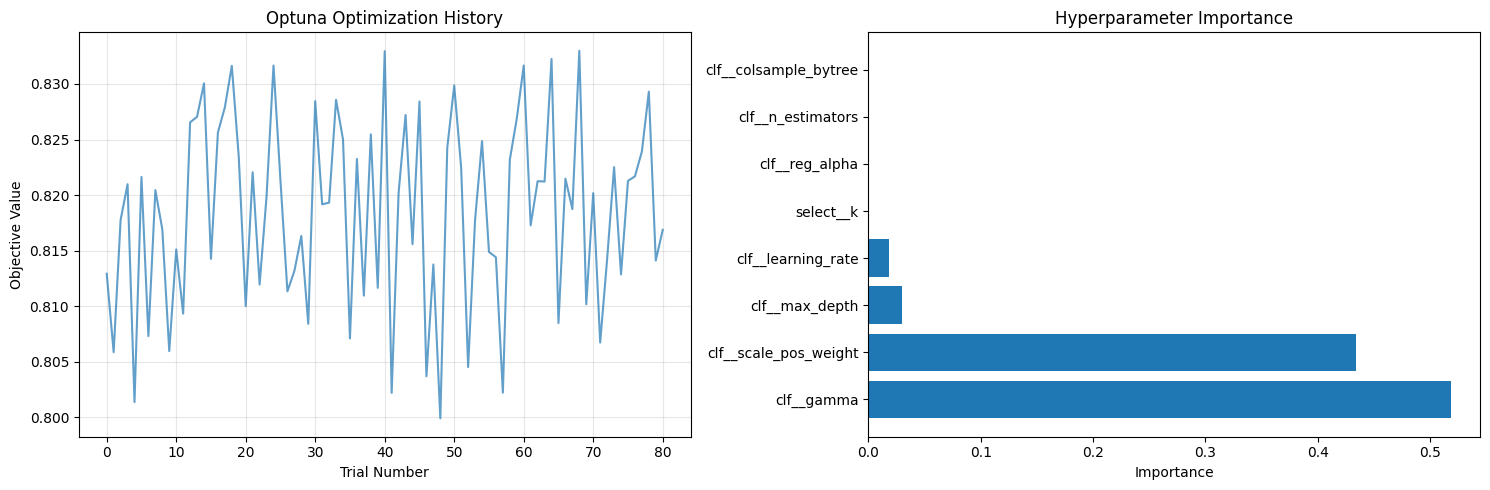


2. Parameter Value Distributions:


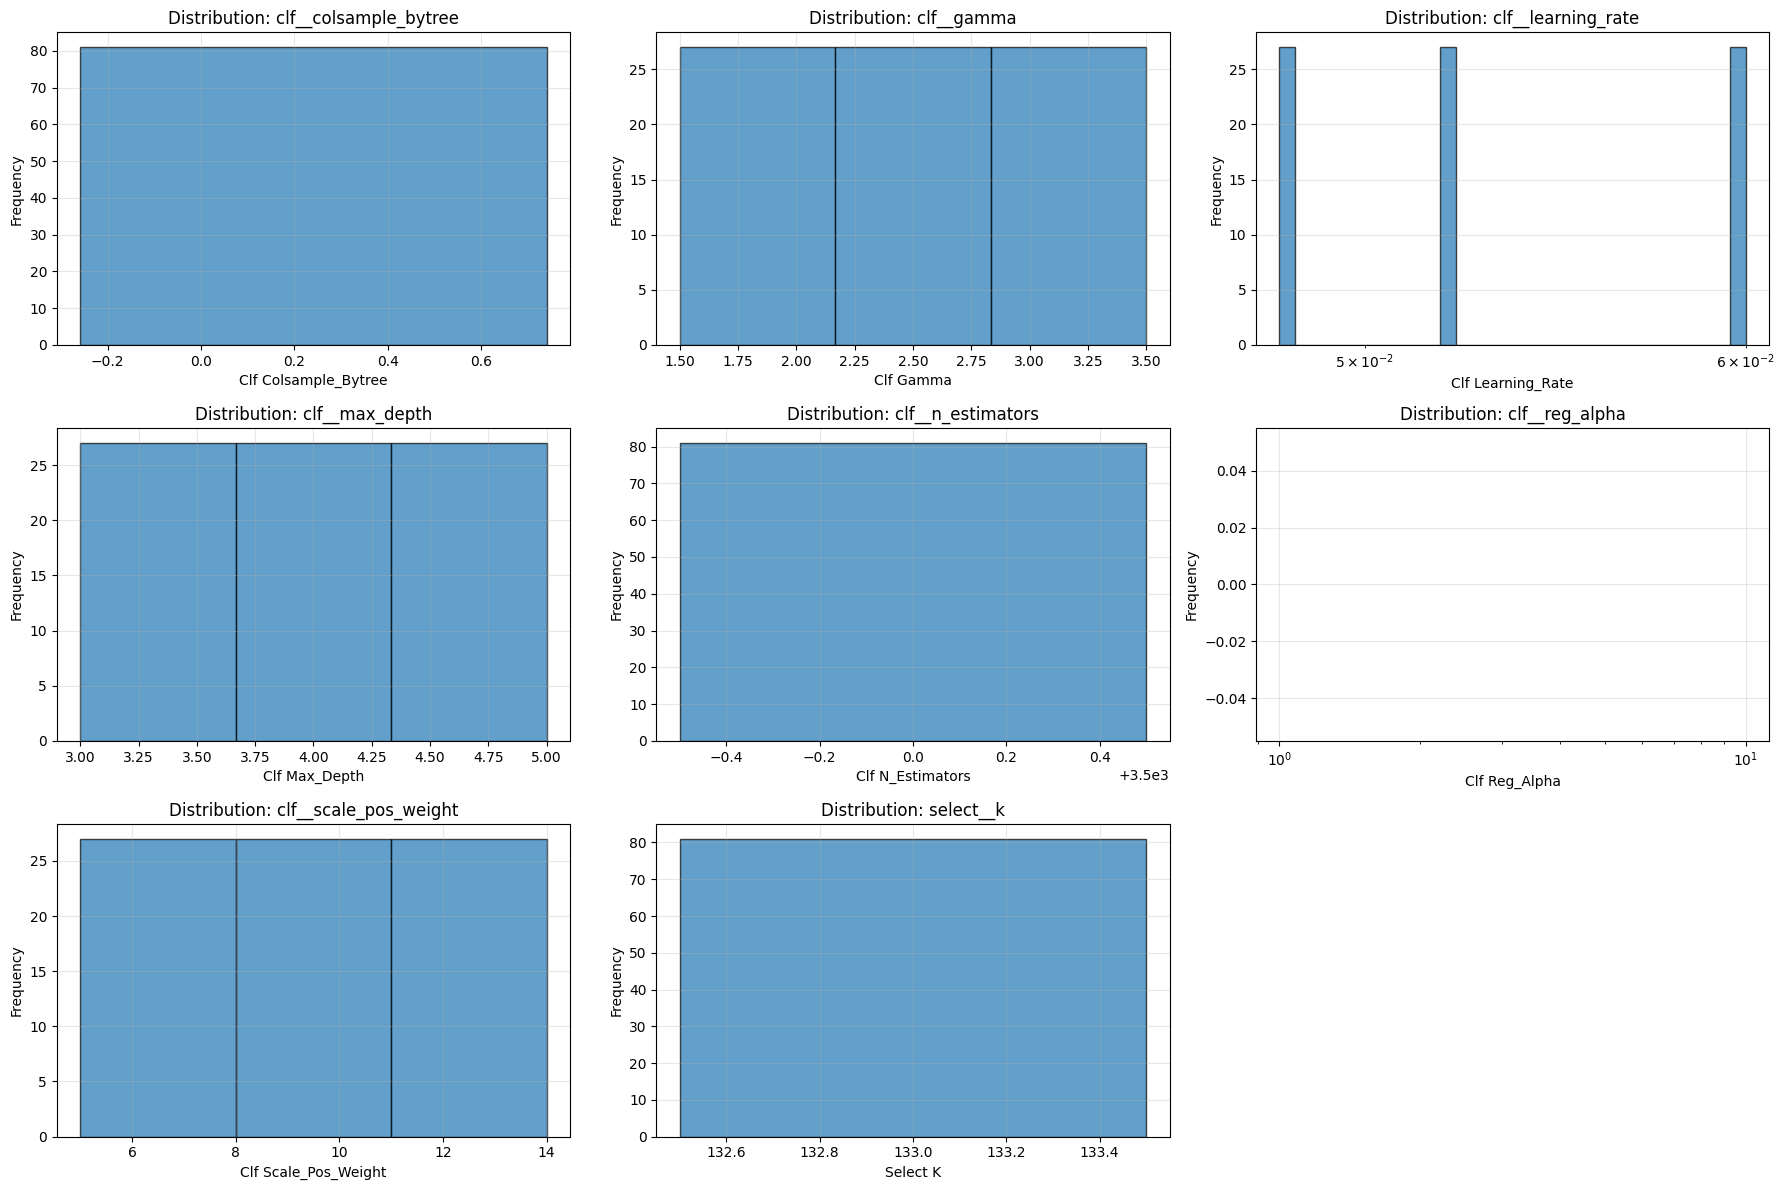


3. Performance vs Individual Parameters:


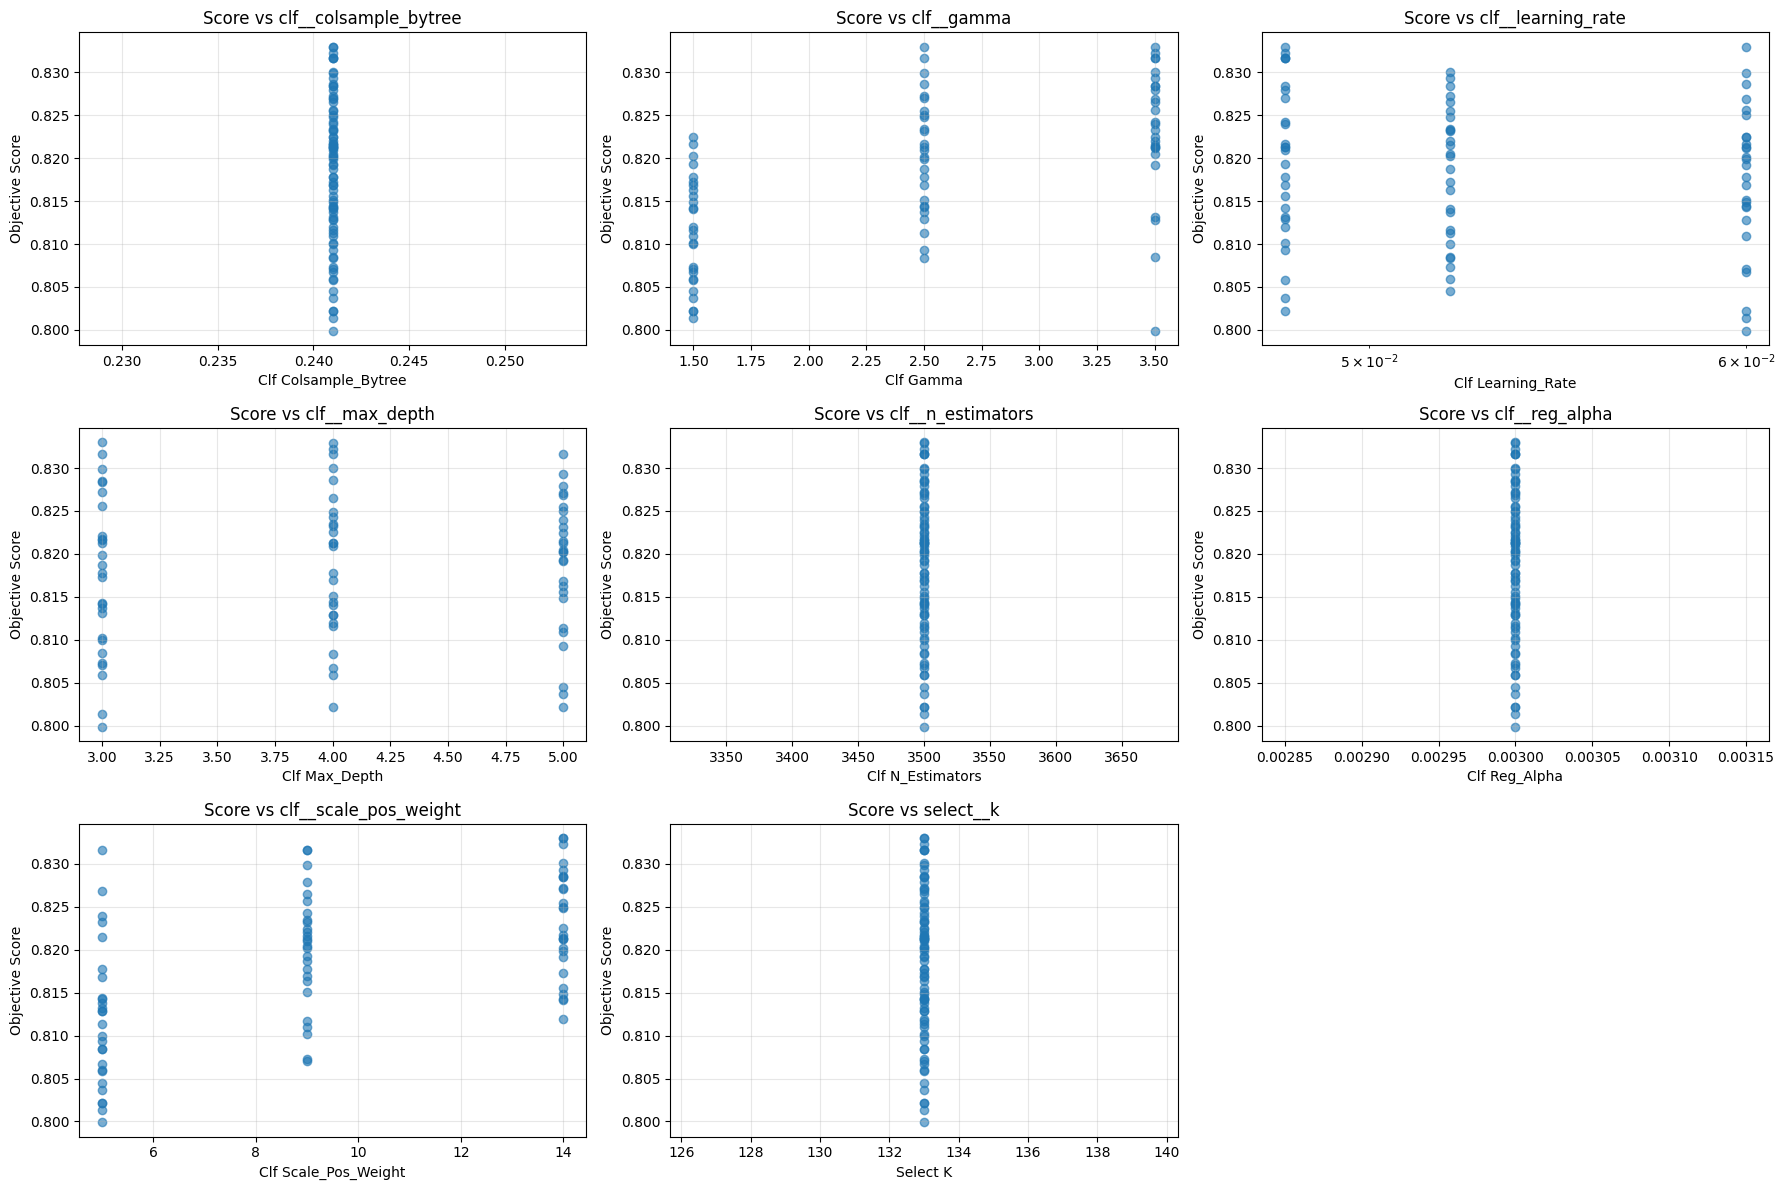


4. Convergence Analysis:


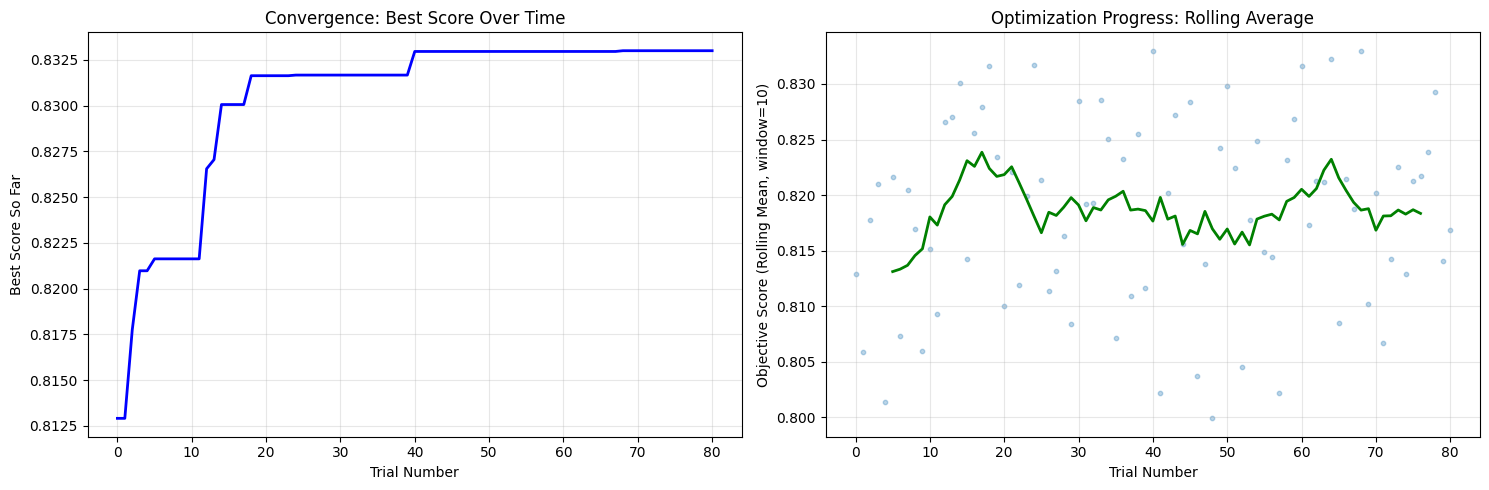


5. Trial Status Overview:


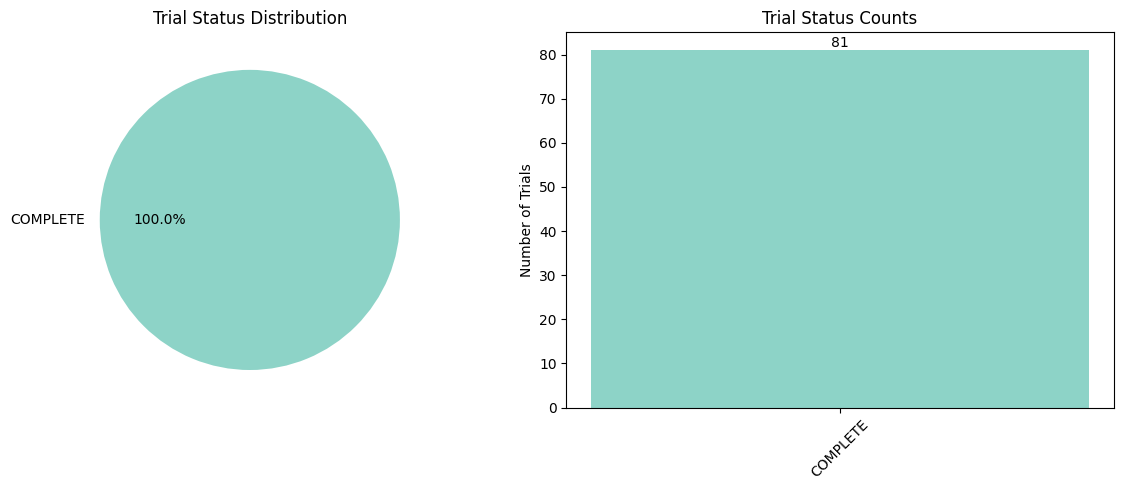


6. Top 10 Best Trials:
Rank Trial#  Score      colsample_bytree gamma        learning_rate max_depth    n_estimators reg_alpha    scale_pos_weight k           
----------------------------------------------------------------------------------------------------------------------------------------
1    68      0.8330     0.2410       2.5000       0.0480       3            3500         0.0030       14.0000      133         
2    40      0.8330     0.2410       3.5000       0.0600       4            3500         0.0030       14.0000      133         
3    64      0.8323     0.2410       3.5000       0.0480       4            3500         0.0030       14.0000      133         
4    24      0.8317     0.2410       2.5000       0.0480       5            3500         0.0030       9.0000       133         
5    60      0.8317     0.2410       3.5000       0.0480       4            3500         0.0030       5.0000       133         
6    18      0.8316     0.2410       3.5000       0.0480      

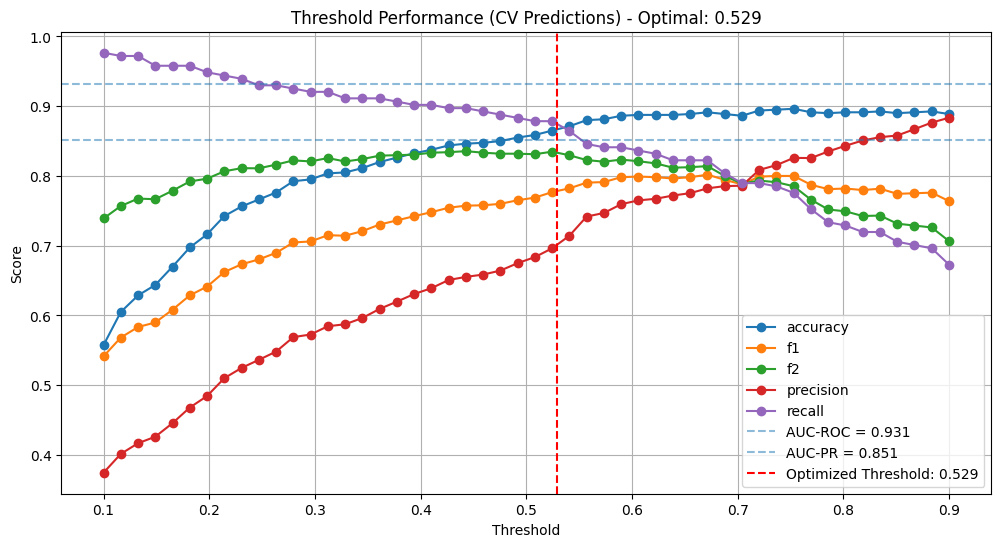

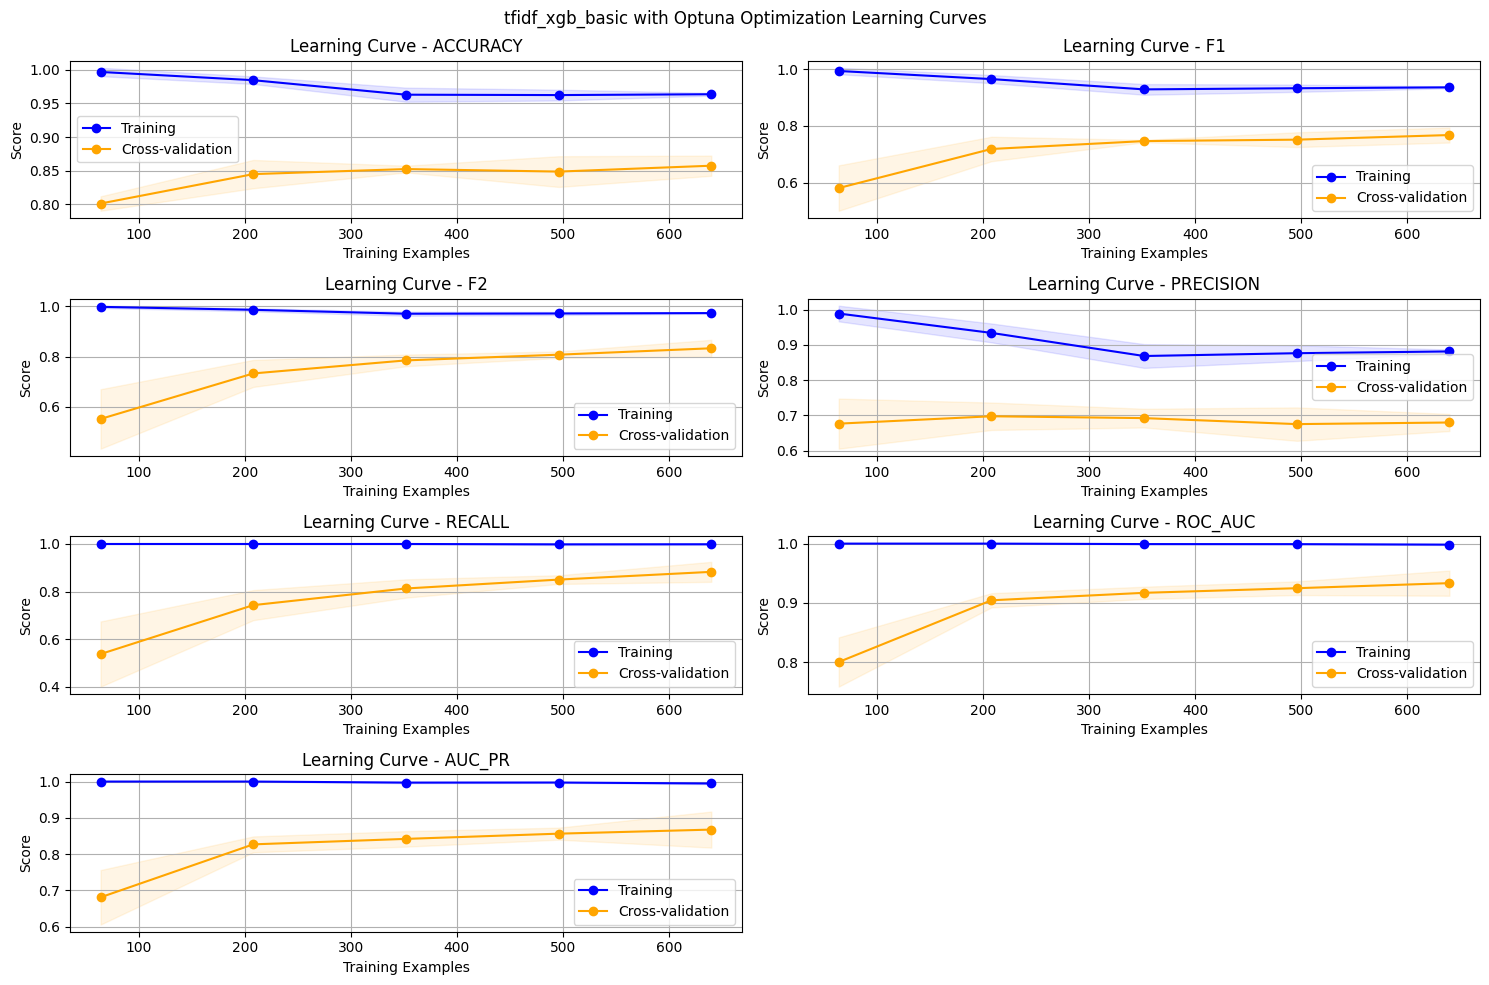


Final Threshold: 0.53

Test Set Performance:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       146
           1       0.69      0.76      0.73        54

    accuracy                           0.84       200
   macro avg       0.80      0.82      0.81       200
weighted avg       0.85      0.84      0.85       200

Additional Metrics:
Accuracy   0.845
F2-score   0.745
AUC-ROC    0.894
AUC-PR     0.814



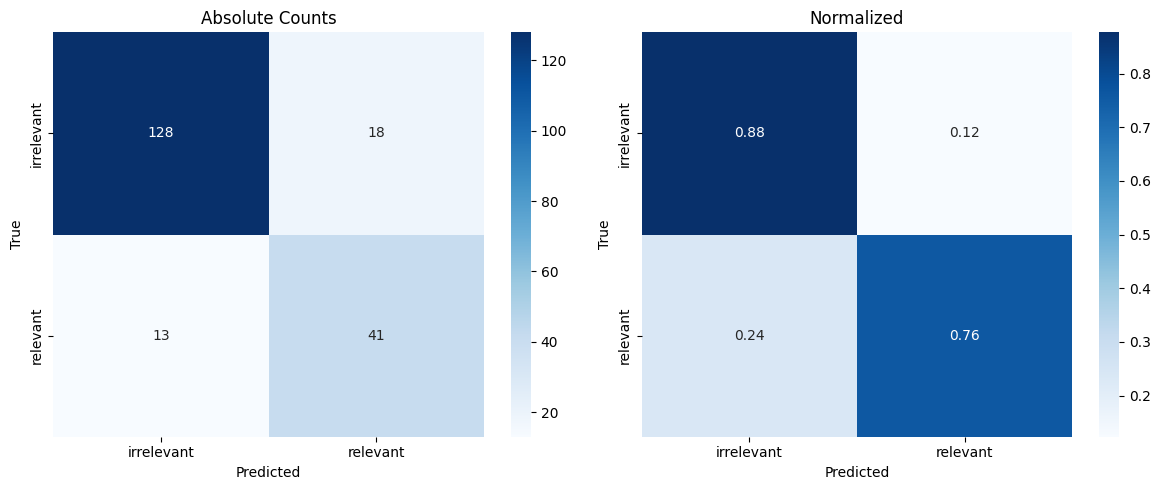

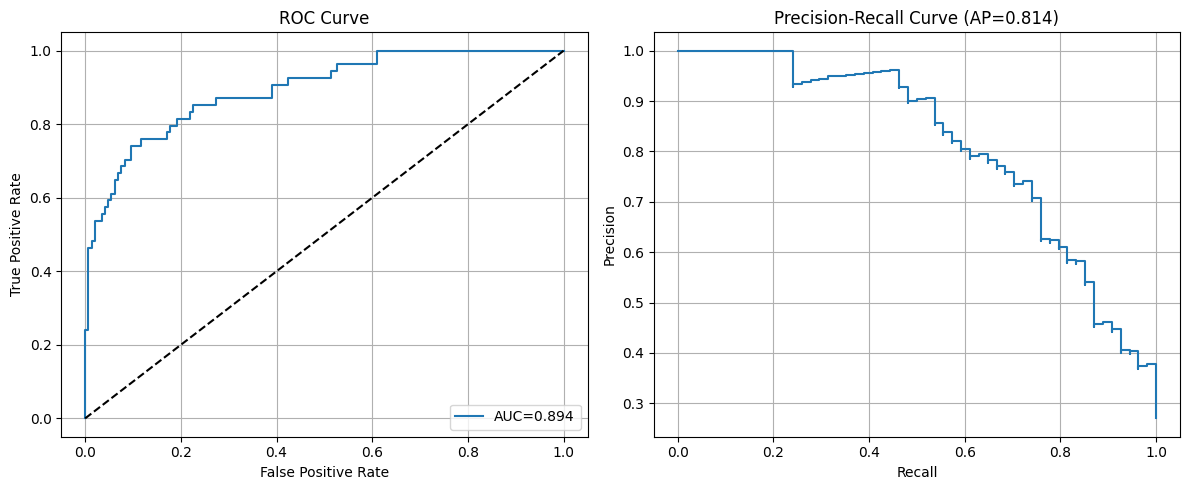


Model saved as model_tfidf_xgb_basic.joblib


In [5]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a XGB classifier 
pipeline_tfidf_xgb = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("clf",     XGBClassifier(
                objective='binary:logistic',
                tree_method='hist',
                n_jobs=-1,  # Use all available CPU cores
                random_state=42,                  
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter grid for gridsearch

param_grid = {
    "clf__learning_rate":    [0.048, 0.052, 0.060],  # peak ~0.05; shrinkage controls overfitting
    "clf__scale_pos_weight": [5.0, 9.0, 14.0],       # matches top-10 modes; tunes class imbalance near neg/pos
    "clf__gamma":            [1.5, 2.5, 3.5],        # winners ~1.3–4.2; conservative split threshold
    "clf__max_depth":        [3, 4, 5],              # shallow trees generalize on sparse TF-IDF
    "clf__n_estimators":     [3500],                 # FIXED (low importance): upper cap; ES keeps best iter
    "clf__colsample_bytree": [0.241],                # FIXED (low importance): best from tpe
    "clf__reg_alpha":        [0.003],                # FIXED (low importance): best from tpe
    "select__k":             [133],                  # FIXED (low importance): best from tpe 
}


model_name = "tfidf_xgb_basic"

#for second search with grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_tfidf_xgb,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")


**b) XGBClassifier based on advanced preprocessed data**

In [7]:
# Load and preprocess data (advanced mode)
df_advancedcleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='advanced'  # basic cleaning mode
)

# Map labels to binary values
df_advancedcleaned['Label'] = df_advancedcleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

XGB TPE advanced

Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(


Best parameters found by Optuna TPE: {'clf__learning_rate': 0.08326168962781369, 'clf__max_depth': 4, 'clf__gamma': 3.5331178281517377, 'clf__n_estimators': 3470, 'clf__colsample_bytree': 0.2808174111322371, 'clf__scale_pos_weight': 7.131592026107356, 'clf__reg_alpha': 0.4040208447268326, 'select__k': 94, 'phrases__enable': False, 'phrases__min_count': 9, 'phrases__threshold': 4.428153485389195}
Best F2 score during optimization: 0.870

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


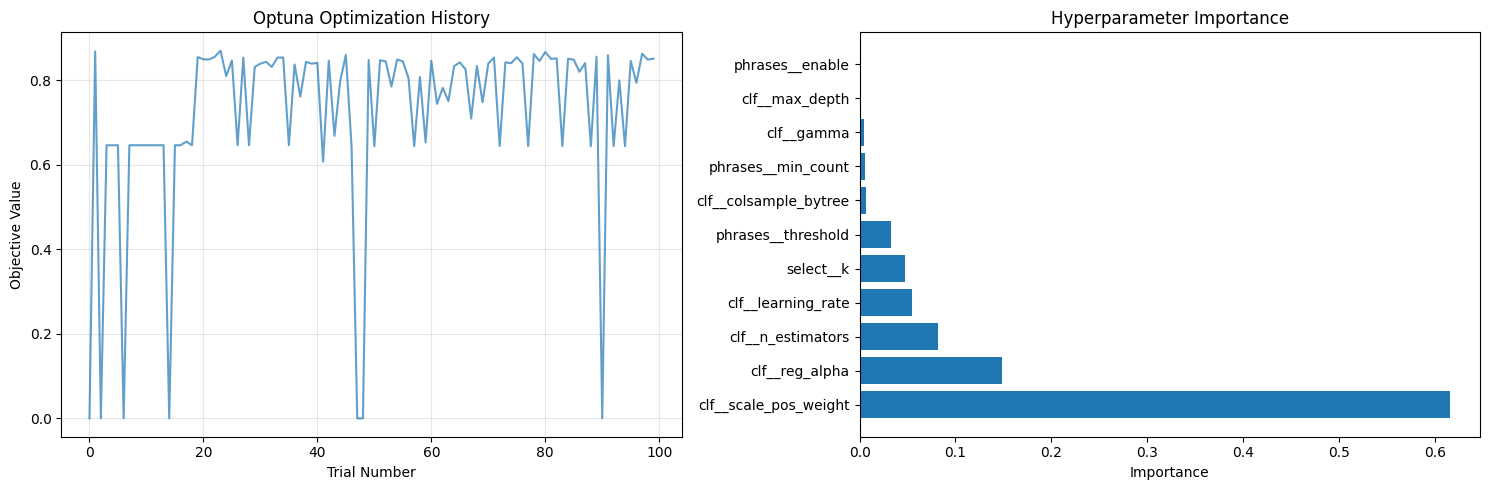


2. Parameter Value Distributions:


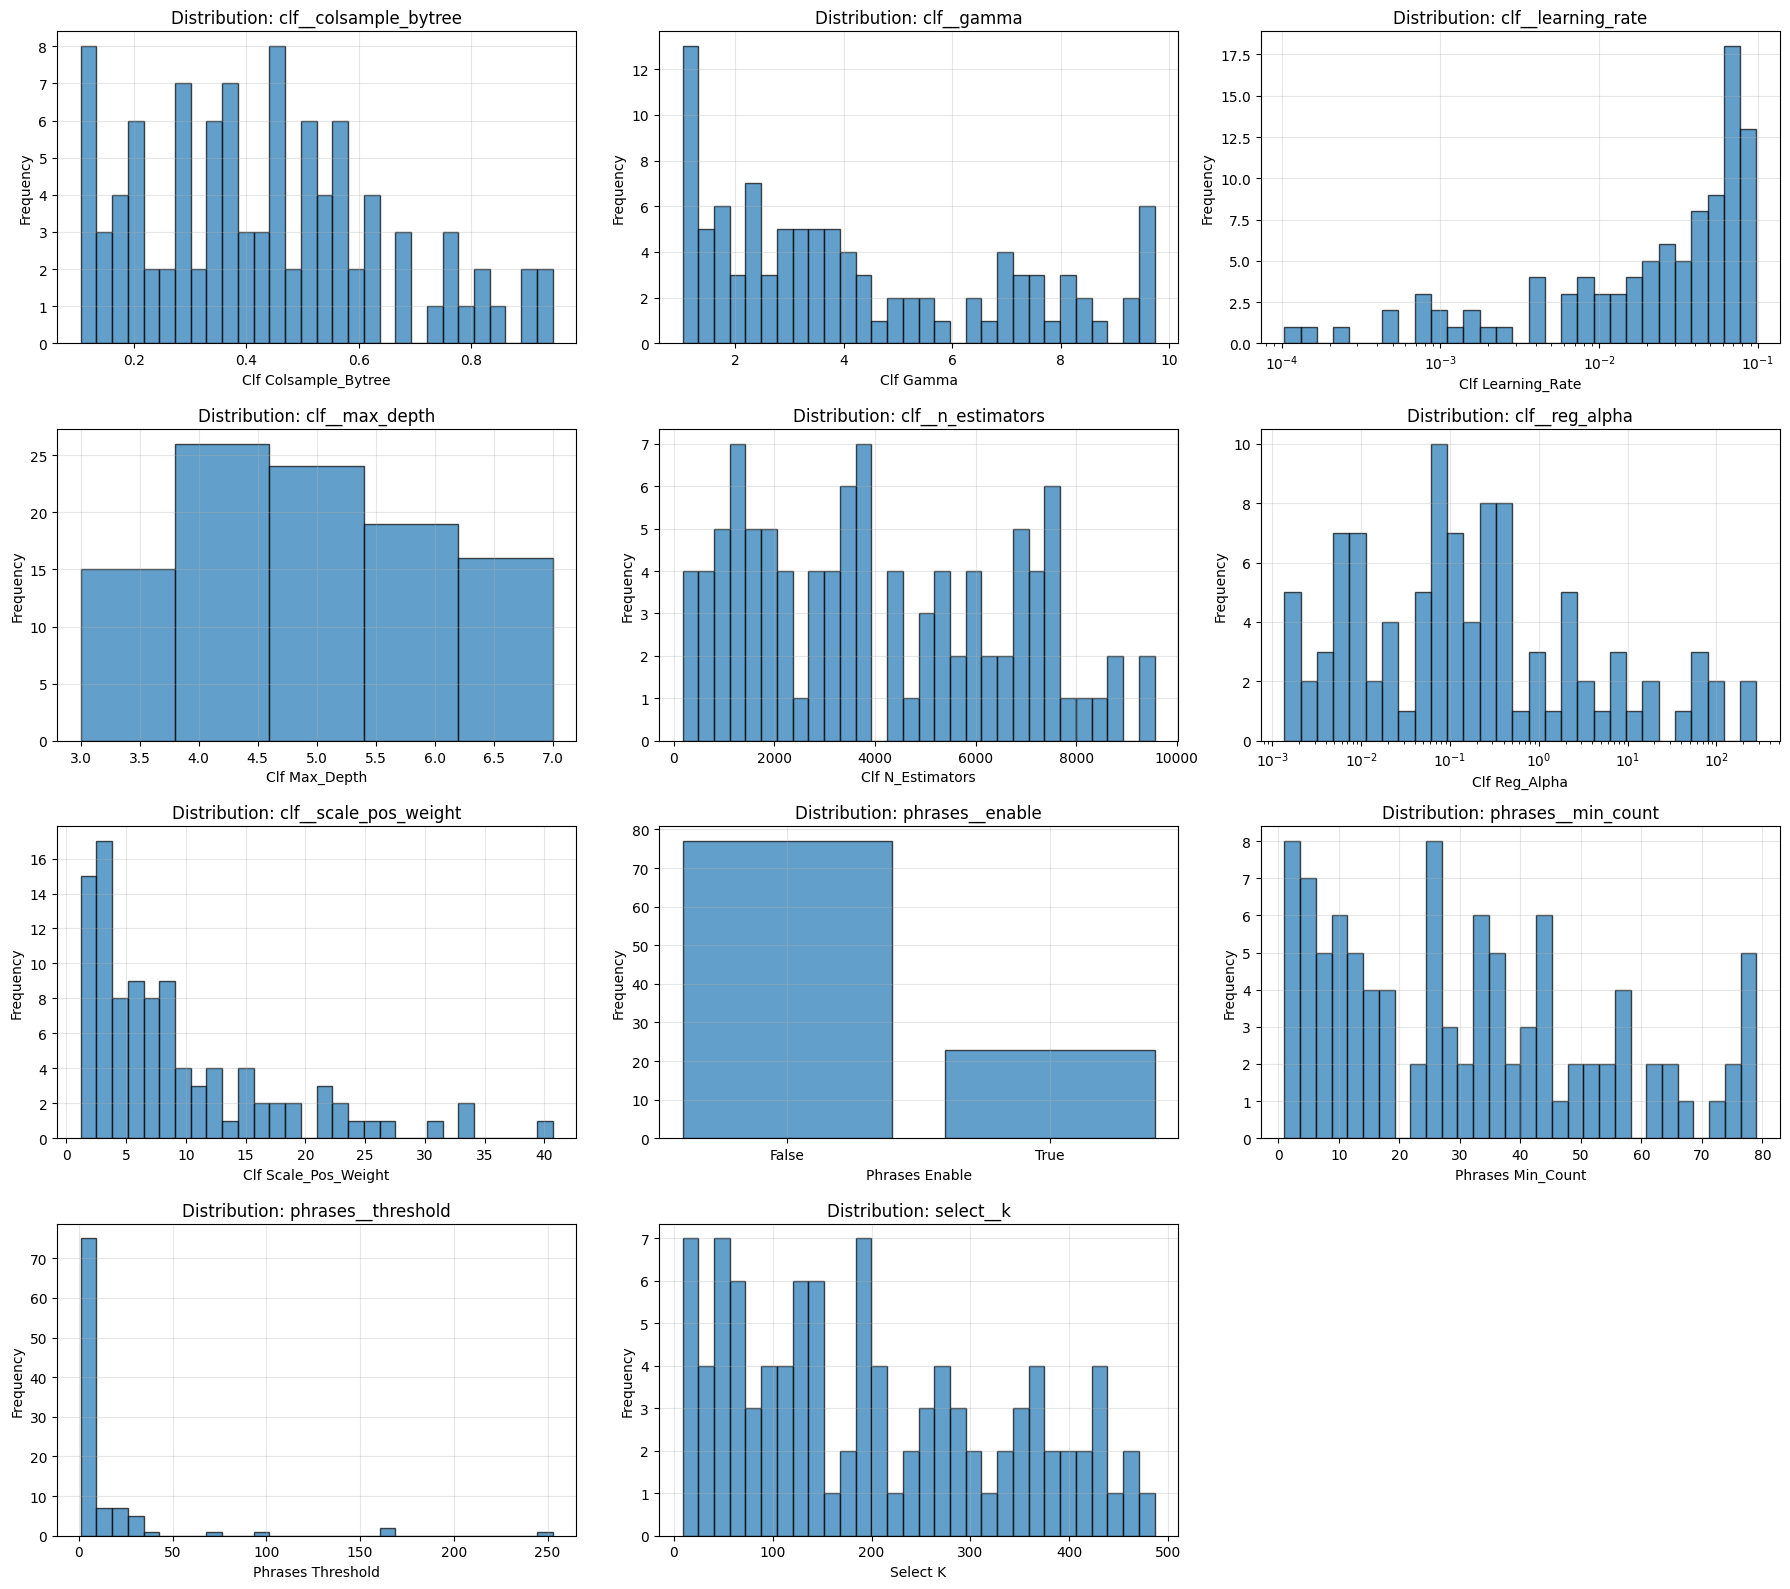


3. Performance vs Individual Parameters:


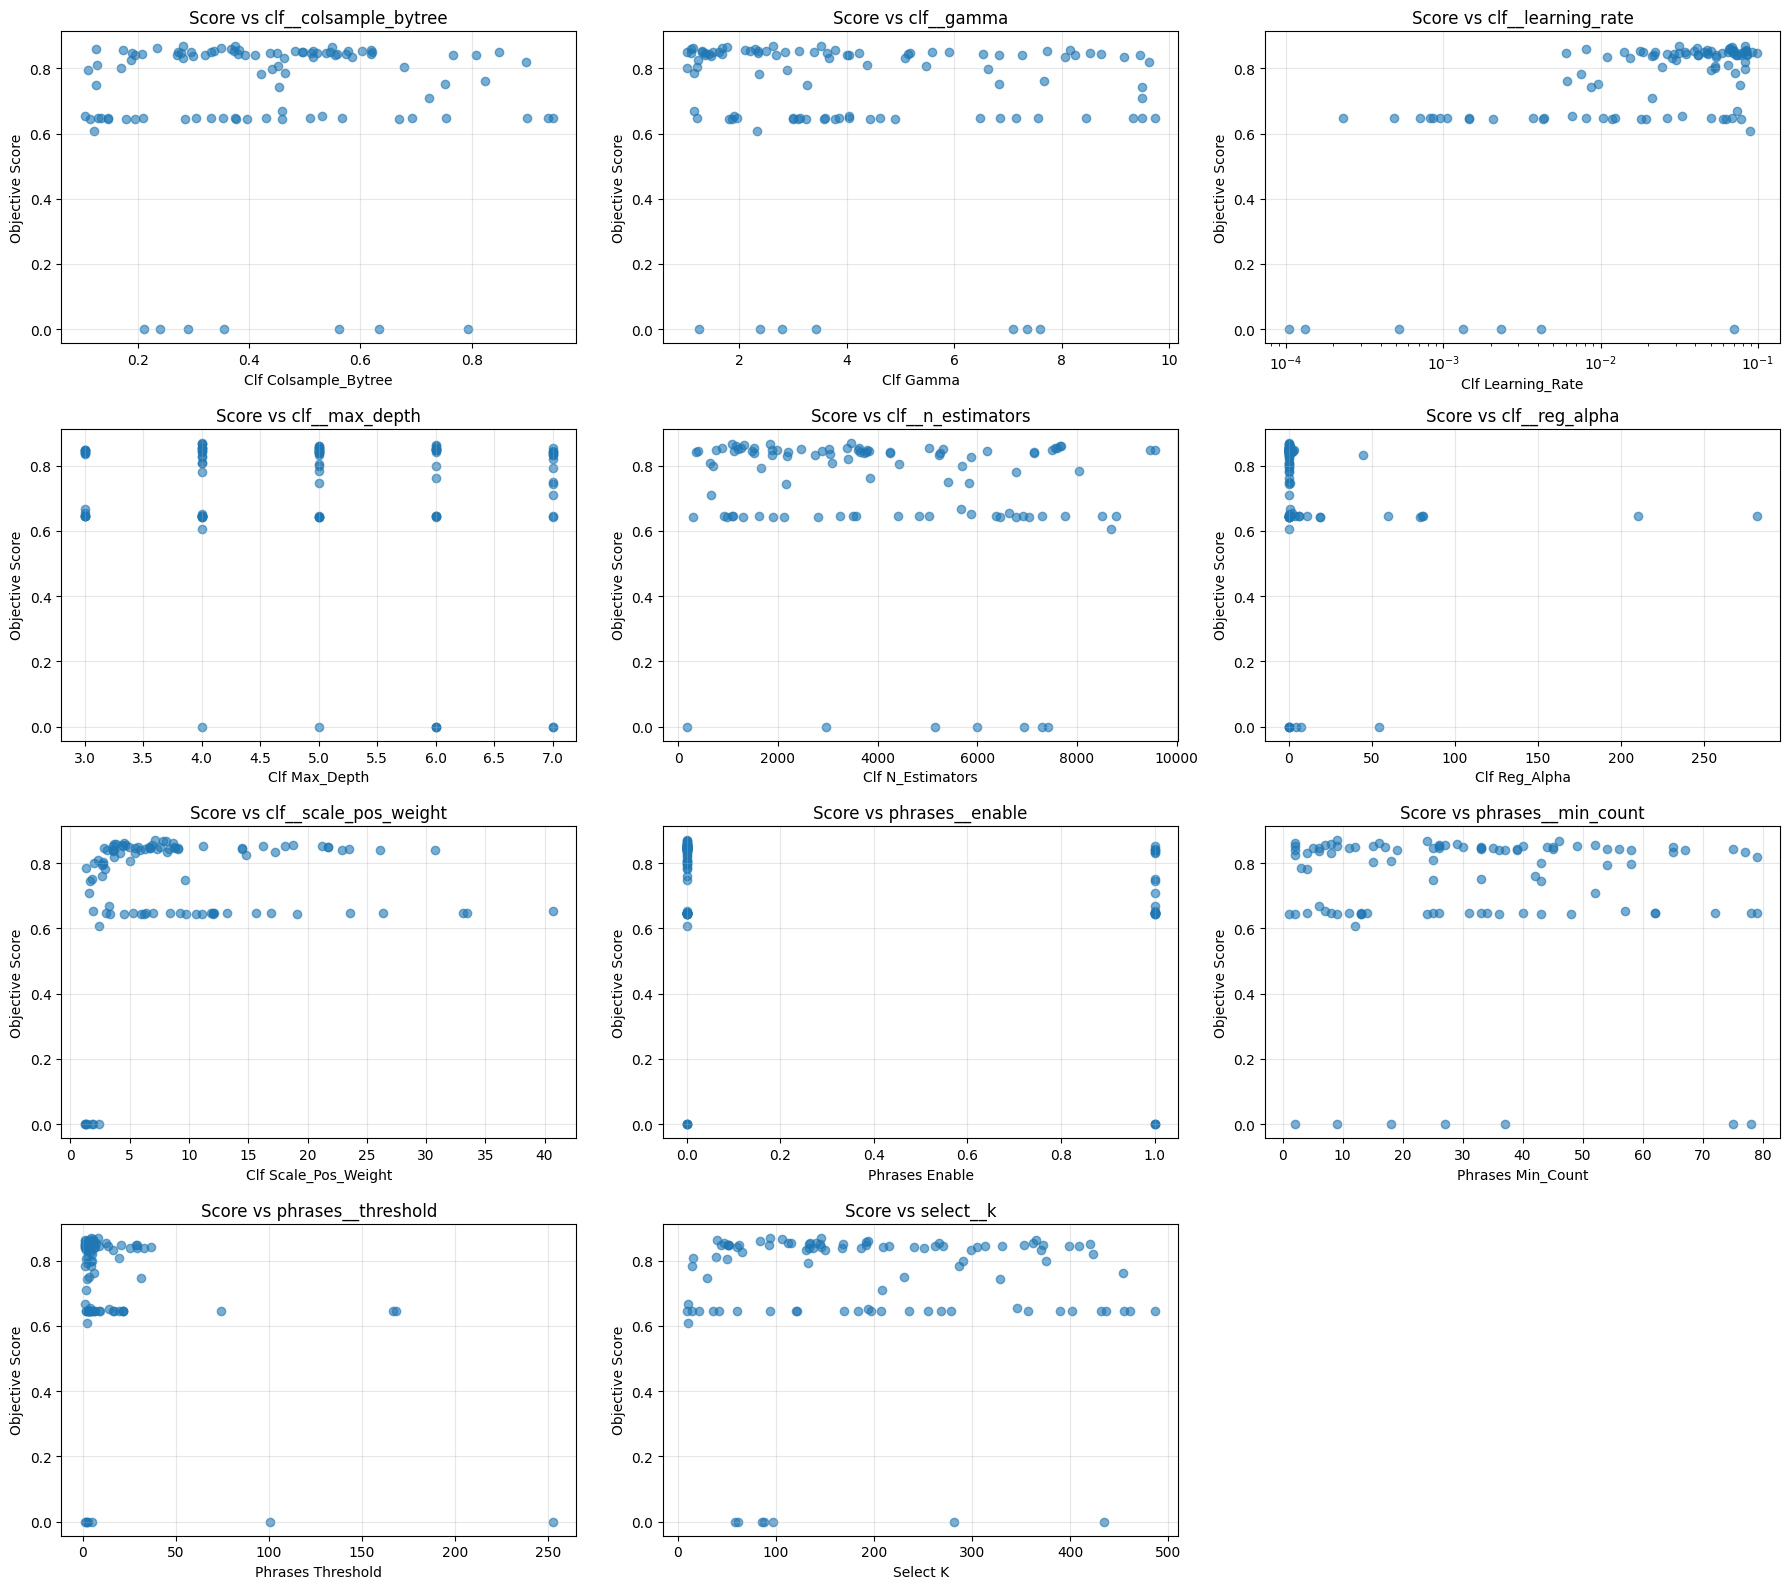


4. Convergence Analysis:


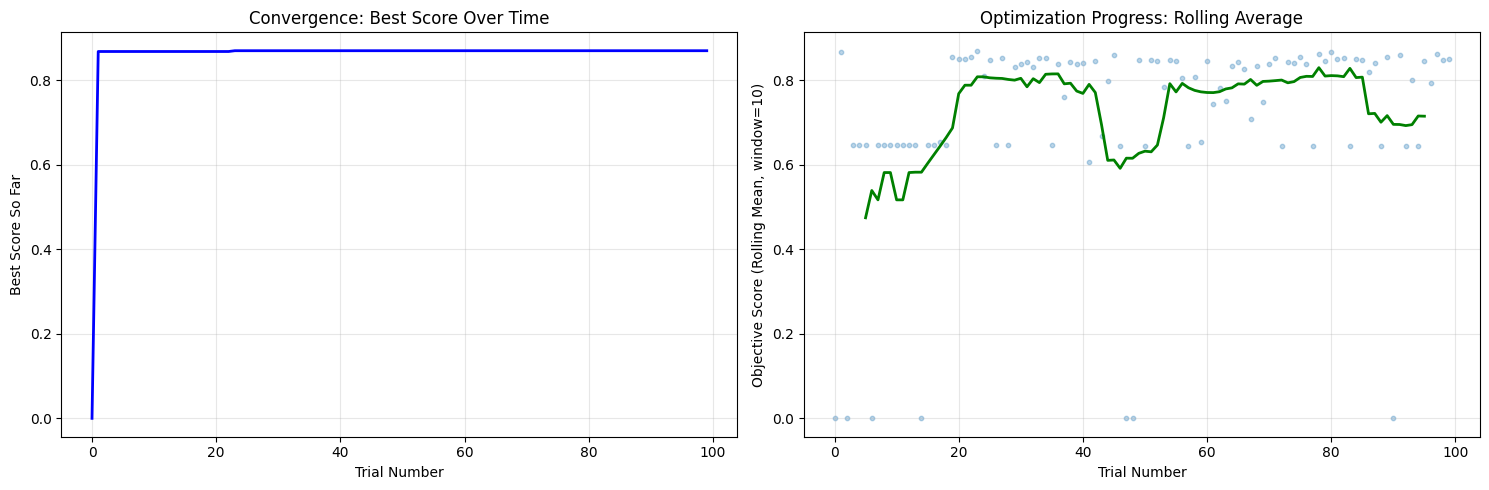


5. Trial Status Overview:


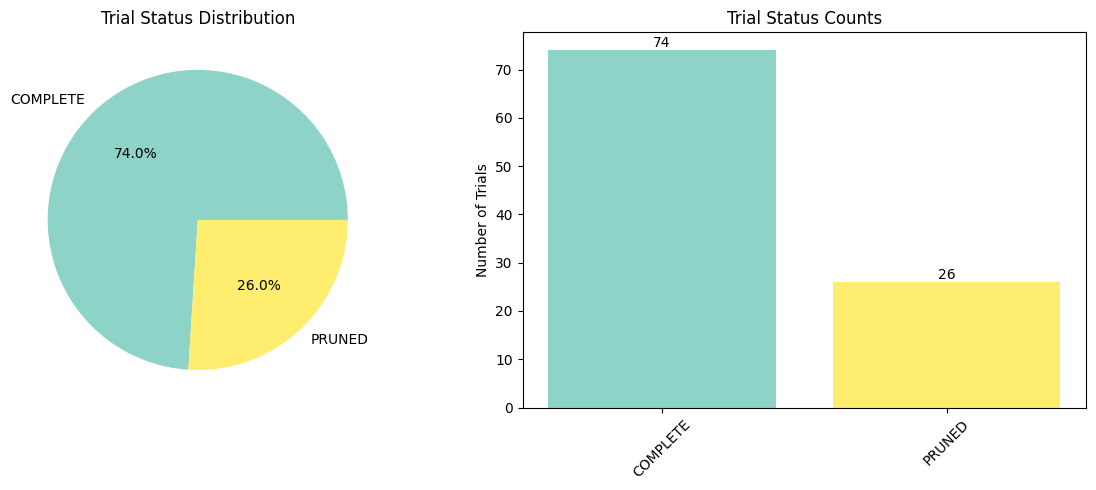


6. Top 10 Best Trials:
Rank Trial#  Score      colsample_bytree gamma        learning_rate max_depth    n_estimators reg_alpha    scale_pos_weight enable       min_count    threshold    k           
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1    23      0.8698     0.2808       3.5331       0.0833       4            3470         0.4040       7.1316       False        9            4.4282       94          
2    1       0.8679     0.3738       2.6364       0.0314       4            1840         0.3905       7.7901       False        24           8.0821       146         
3    80      0.8667     0.5486       1.7713       0.0688       4            1080         0.4938       8.0470       False        46           5.2811       106         
4    97      0.8629     0.2346       1.6927       0.0660       6            1320         0.0082       8.6405       False   

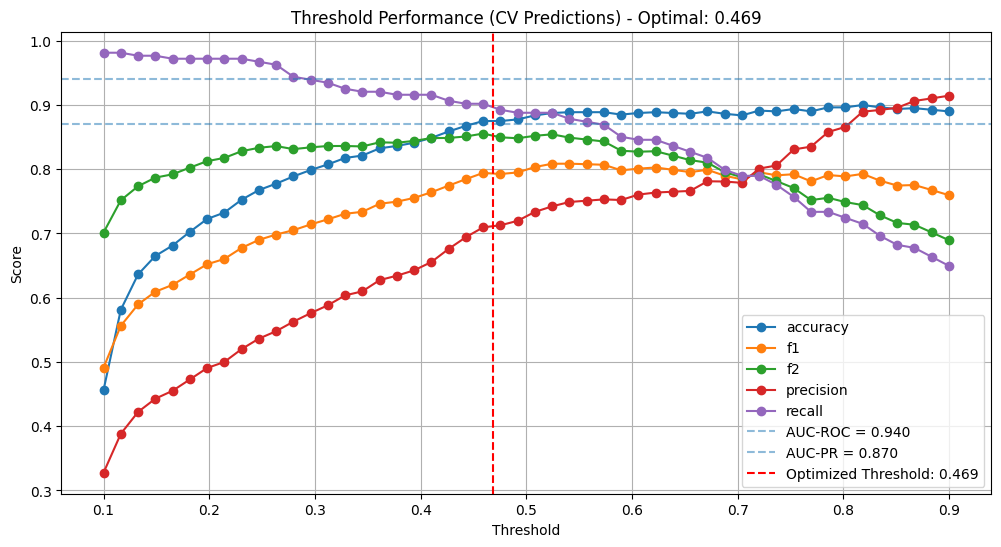

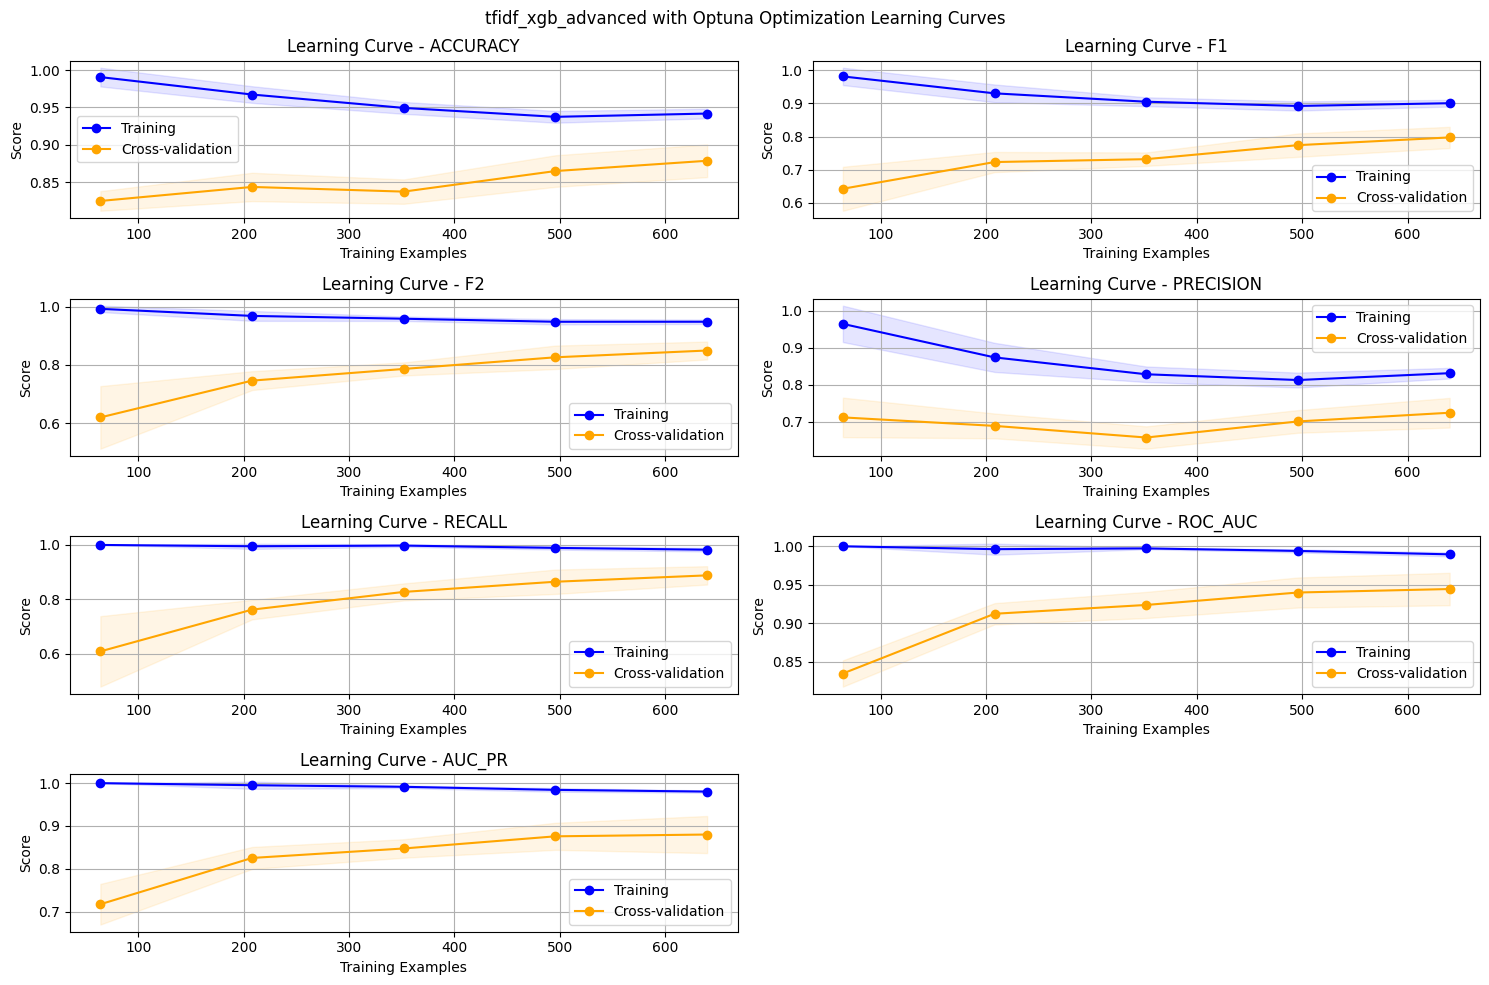


Final Threshold: 0.47

Test Set Performance:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       146
           1       0.63      0.74      0.68        54

    accuracy                           0.81       200
   macro avg       0.77      0.79      0.78       200
weighted avg       0.83      0.81      0.82       200

Additional Metrics:
Accuracy   0.815
F2-score   0.717
AUC-ROC    0.906
AUC-PR     0.830



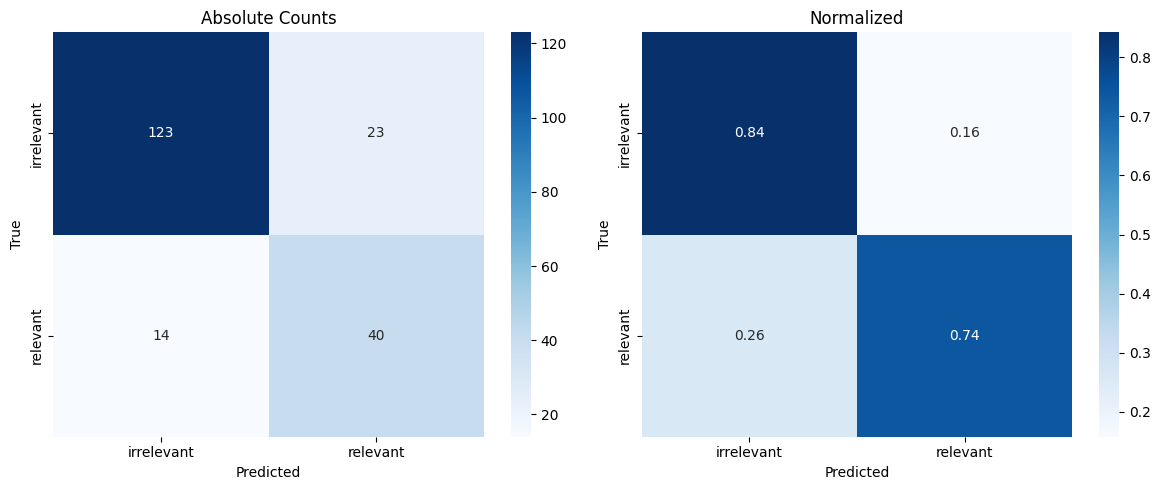

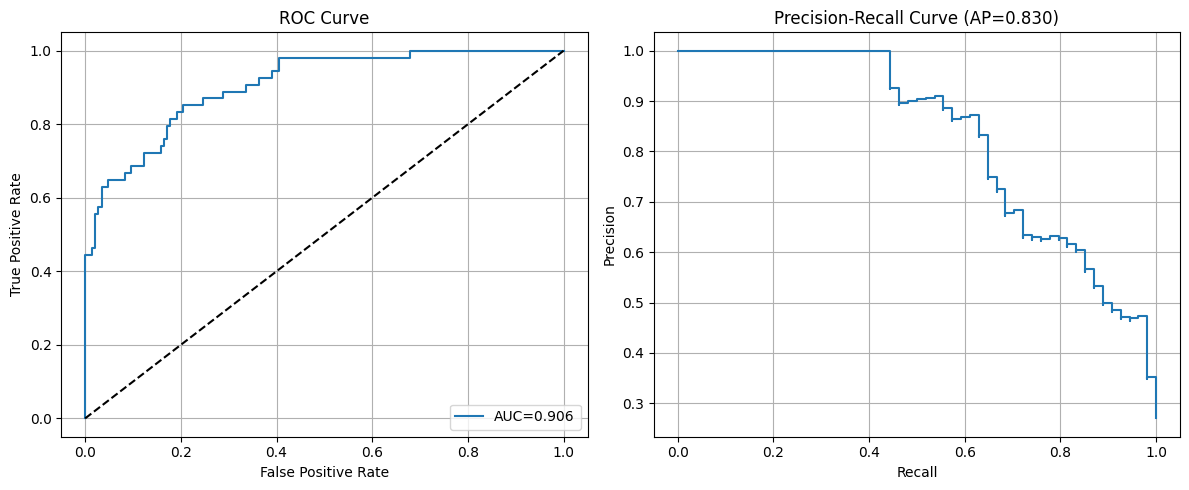


Model saved as model_tfidf_xgb_advanced.joblib


In [8]:
#perform train-test split on advanced cleaned data
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a XGB classifier 
pipeline_tfidf_xgb = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("clf",     XGBClassifier(
                objective='binary:logistic',
                tree_method='hist',
                n_jobs=-1,  # Use all available CPU cores
                random_state=42,                  
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
param_space = {
    "clf__learning_rate":    lambda t: t.suggest_float("clf__learning_rate", 1e-4, 1e-1, log=True),   #  Reusens et al. ranges; log-scale matches multiplicative sensitivity of LR
    "clf__max_depth":        lambda t: t.suggest_int("clf__max_depth", 3, 7),                         #  Reusens et al.: shallow trees fit high-dim sparse TF-IDF features
    "clf__gamma":            lambda t: t.suggest_float("clf__gamma", 1.0, 10.0),                      #  Reusens et al.: minimum loss reduction to make a split (regularizes splits)
    "clf__n_estimators":     lambda t: t.suggest_int("clf__n_estimators", 10, 10000, step=10),        #  Reusens et al.: upper bound; Early Stopping in  objective picks best iteration
    "clf__colsample_bytree": lambda t: t.suggest_float("clf__colsample_bytree", 0.1, 1.0),            #  Reusens et al.: feature subsampling per tree; helps generalization with many sparse features
    "clf__scale_pos_weight": lambda t: t.suggest_float("clf__scale_pos_weight", 1.0, 50.0, log=True), #  XGBoost-native class balancing; typical anchor is sum(neg)/sum(pos). Search narrowly (±~3x, log) around data-driven ratio.
    "clf__reg_alpha":        lambda t: t.suggest_float("clf__reg_alpha", 1e-3, 1e+3, log=True),       # useful L1 on leaf weights: promotes conservatism/sparsity in tree outputs; kept narrow & log to avoid bloating search
    "select__k":             lambda t: t.suggest_int("select__k", 1, 500, step=1),                    # Consistent with  template; chi² directly controls dimensionality (requires non-negative features)
    "phrases__enable":      lambda t: t.suggest_categorical("phrases__enable", [False, True]),        # 3 Parameters enabled in our advanced (multi word grouping) pipeline.
    "phrases__min_count":   lambda t: t.suggest_int("phrases__min_count", 1, 80),
    "phrases__threshold":   lambda t: t.suggest_float("phrases__threshold", 1.0, 300.0, log=True)
}

model_name = "tfidf_xgb_advanced"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_tfidf_xgb,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    model_type = "xgboost",
    n_trials=100,  # Intelligent search with early stopping
    direction="maximize",
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name=model_name
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")

XGB GridSearch advanced

Starting Optuna hyperparameter optimization ...
Best parameters found by Optuna TPE: {'clf__learning_rate': 0.1, 'clf__n_estimators': 3900, 'clf__scale_pos_weight': 20.0, 'clf__reg_alpha': 0.4, 'select__k': 120, 'clf__max_depth': 4, 'clf__gamma': 2.0, 'clf__colsample_bytree': 0.3, 'phrases__enable': False}
Best F2 score during optimization: 0.853

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


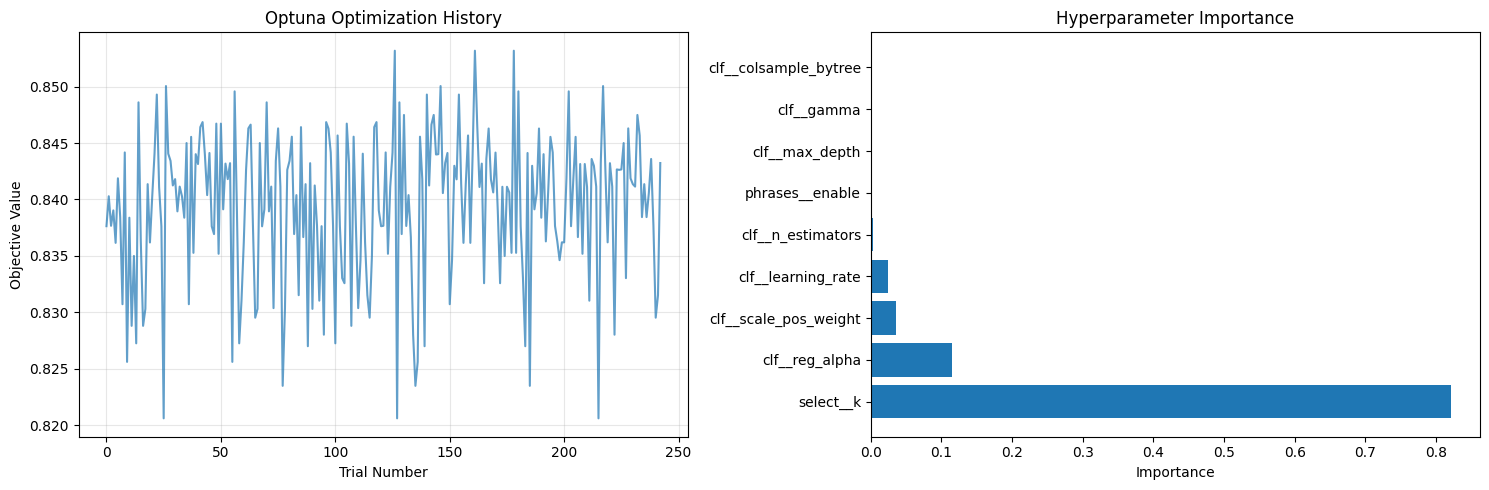


2. Parameter Value Distributions:


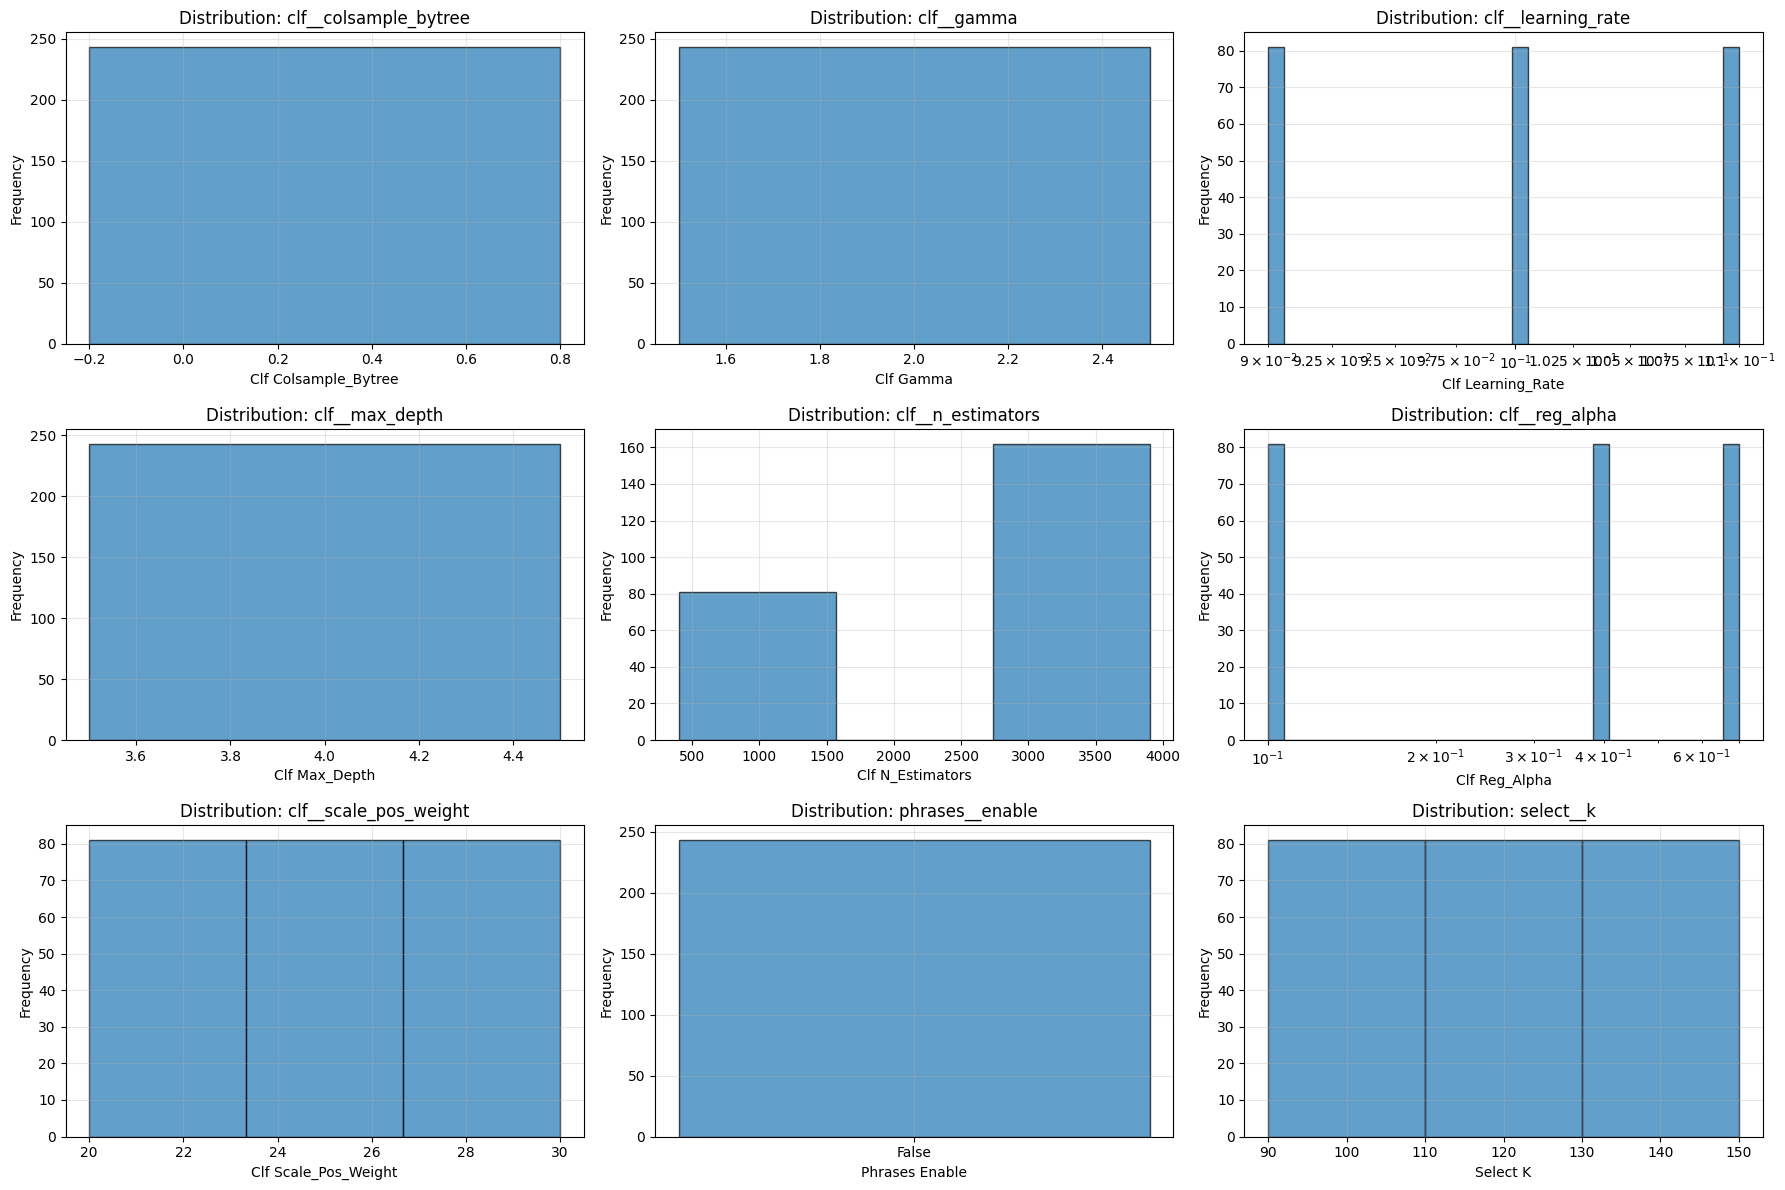


3. Performance vs Individual Parameters:


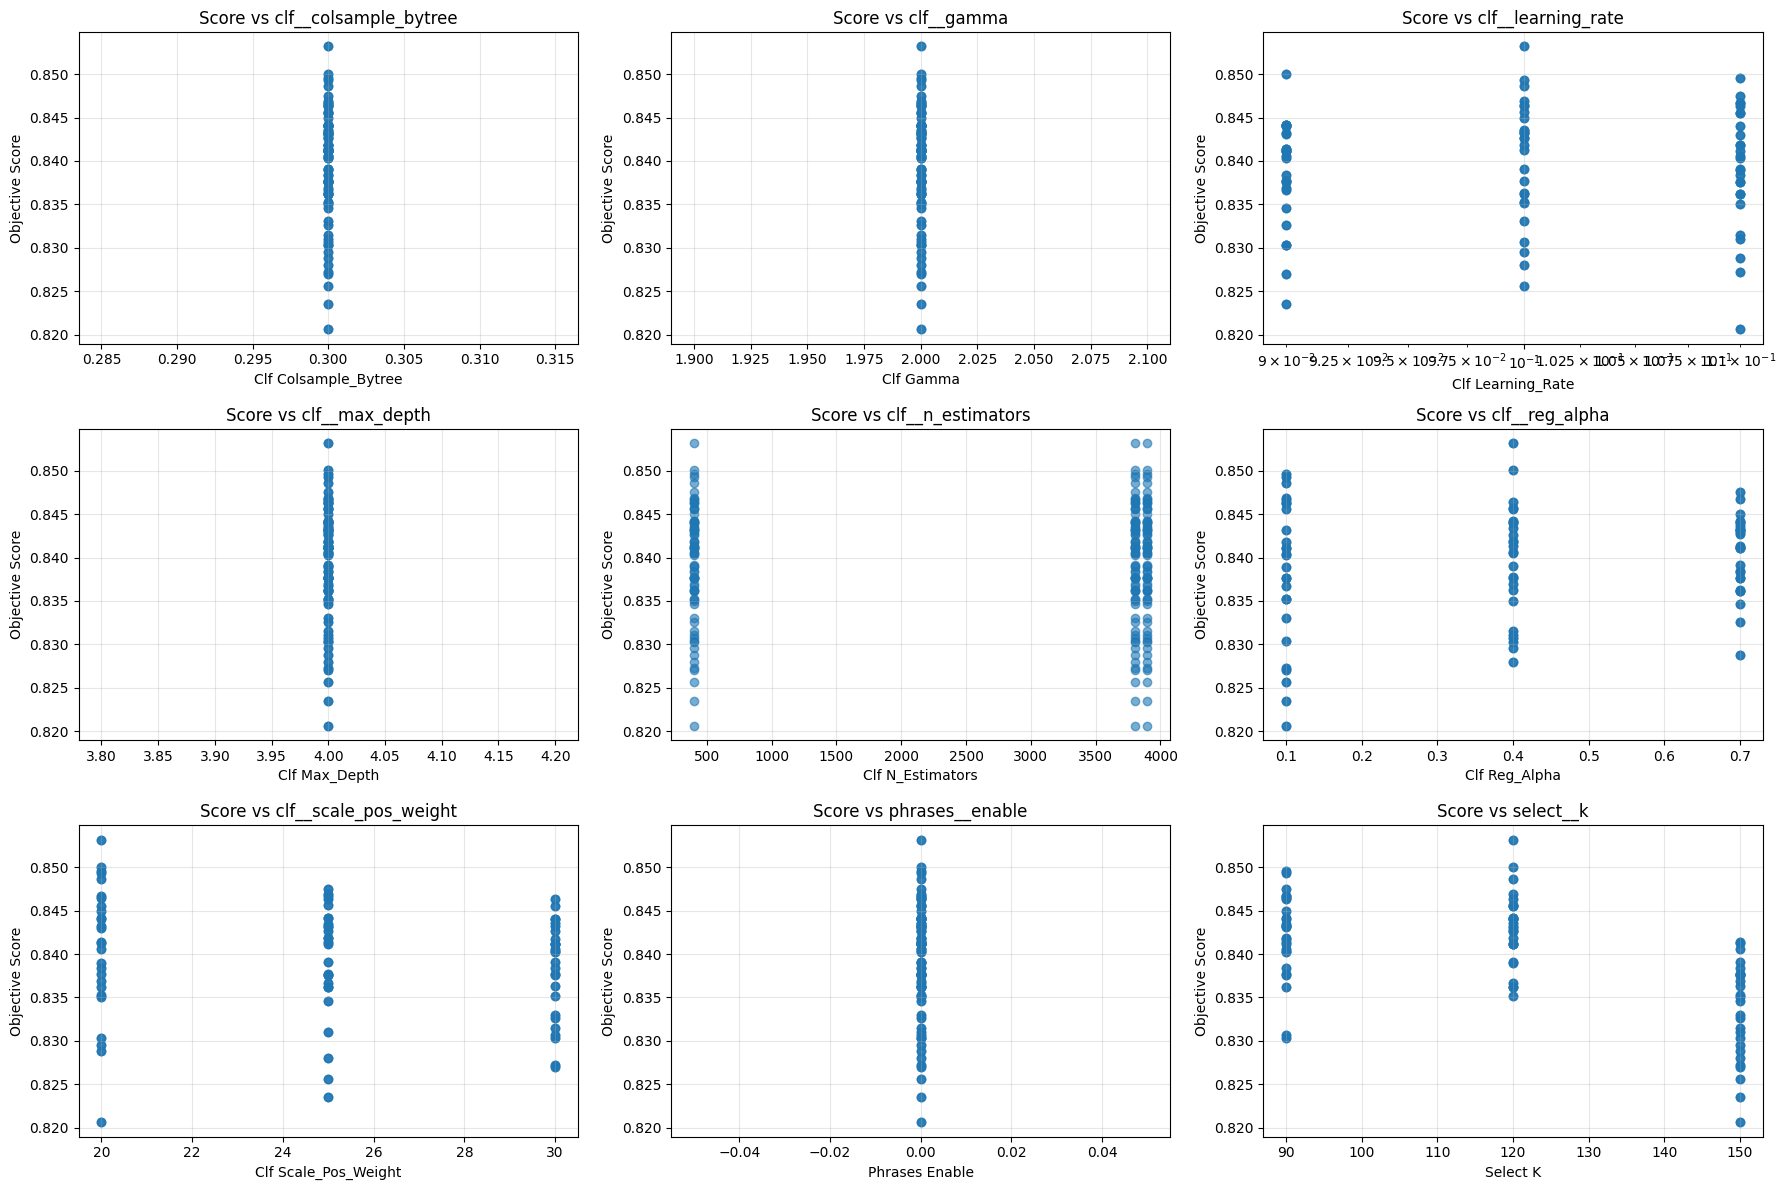


4. Convergence Analysis:


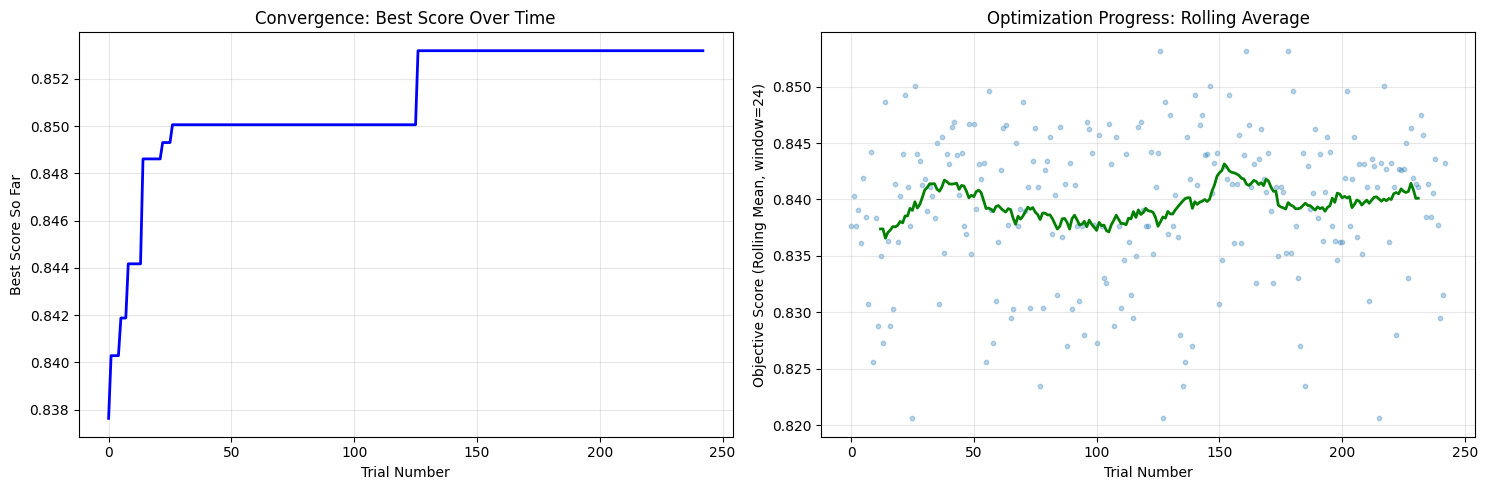


5. Trial Status Overview:


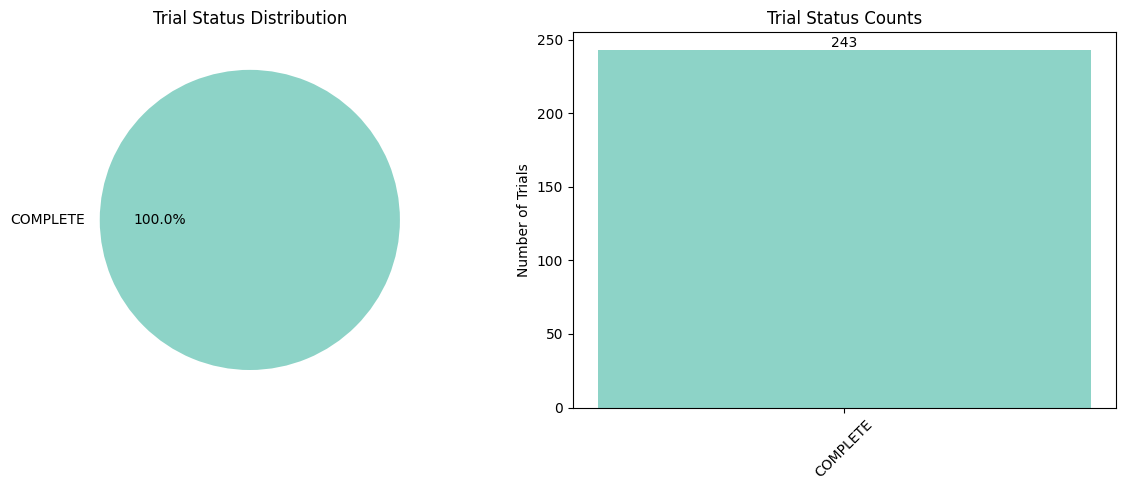


6. Top 10 Best Trials:
Rank Trial#  Score      colsample_bytree gamma        learning_rate max_depth    n_estimators reg_alpha    scale_pos_weight enable       k           
-----------------------------------------------------------------------------------------------------------------------------------------------------
1    126     0.8532     0.3000       2.0000       0.1000       4            3900         0.4000       20.0000      False        120         
2    161     0.8532     0.3000       2.0000       0.1000       4            400          0.4000       20.0000      False        120         
3    178     0.8532     0.3000       2.0000       0.1000       4            3800         0.4000       20.0000      False        120         
4    26      0.8501     0.3000       2.0000       0.0900       4            3800         0.4000       20.0000      False        120         
5    146     0.8501     0.3000       2.0000       0.0900       4            400          0.4000       20.0000   

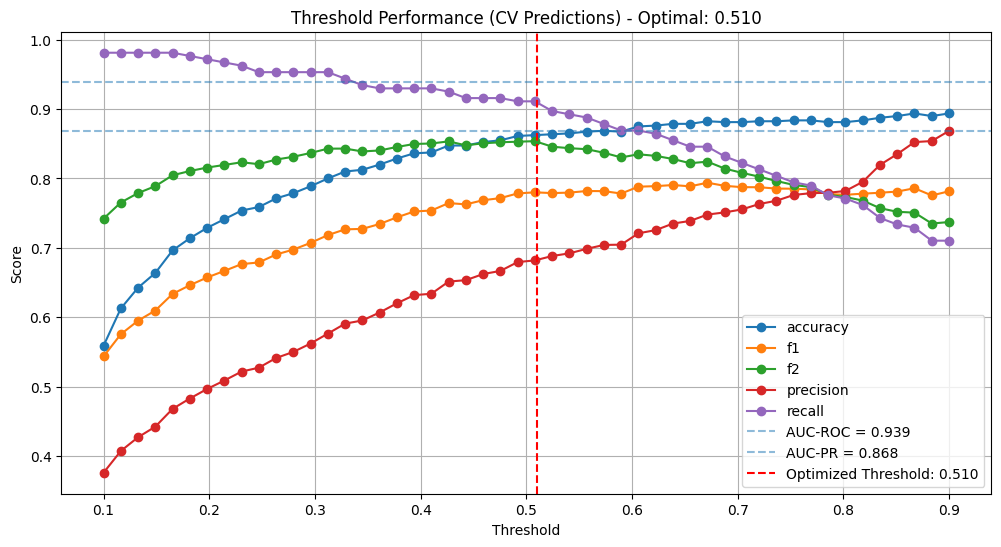

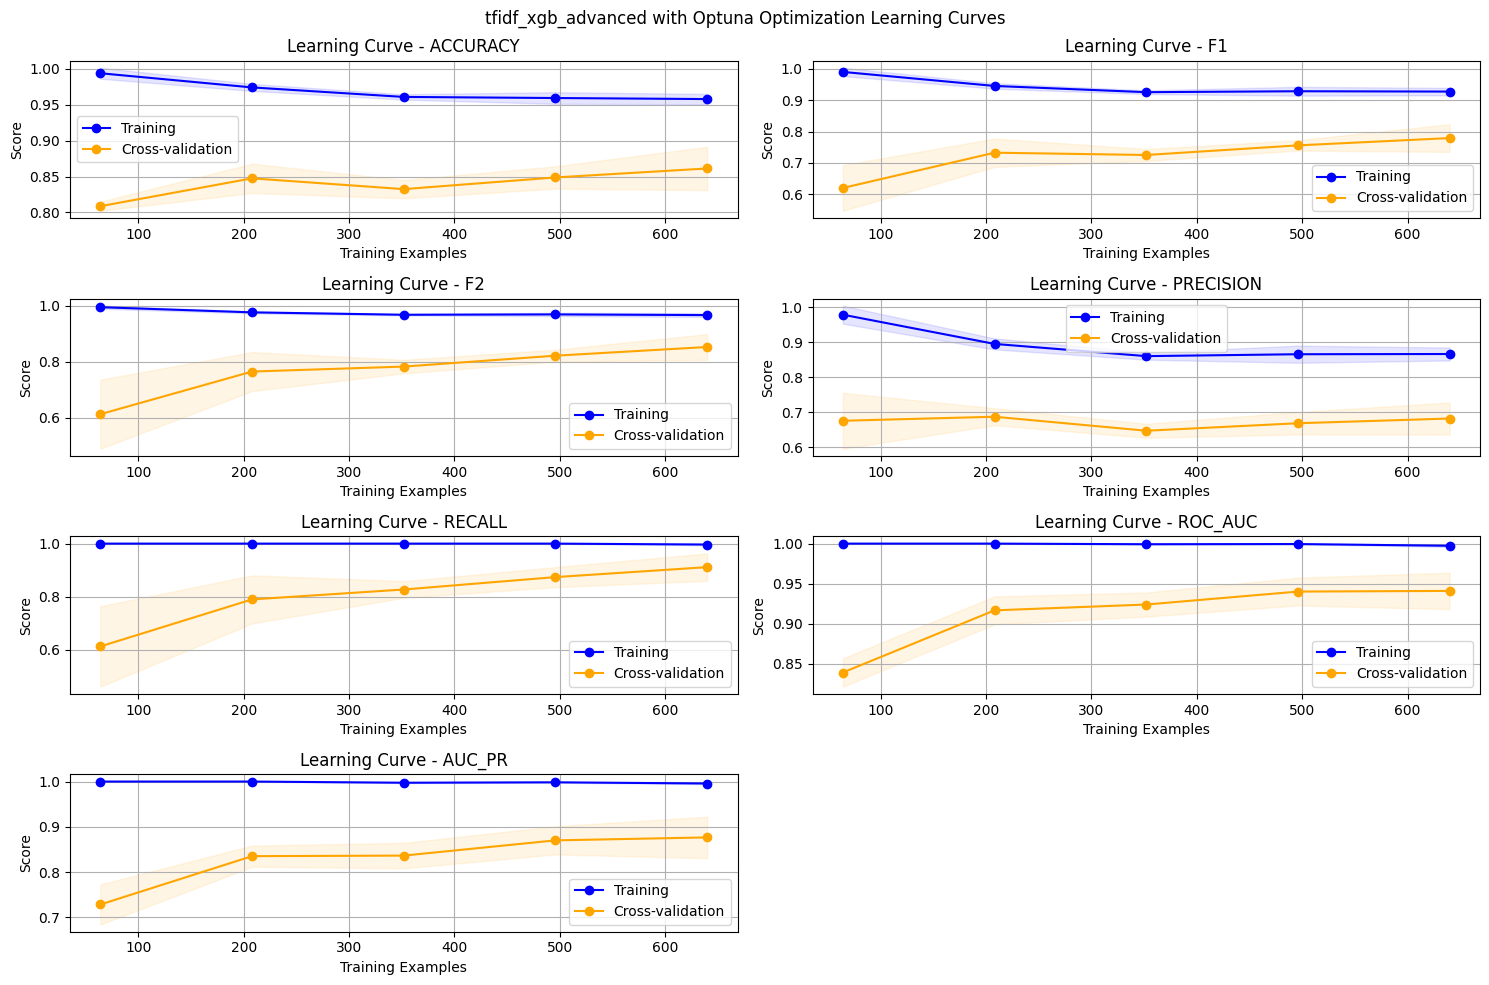


Final Threshold: 0.51

Test Set Performance:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       146
           1       0.66      0.78      0.71        54

    accuracy                           0.83       200
   macro avg       0.78      0.81      0.80       200
weighted avg       0.84      0.83      0.83       200

Additional Metrics:
Accuracy   0.830
F2-score   0.750
AUC-ROC    0.900
AUC-PR     0.814



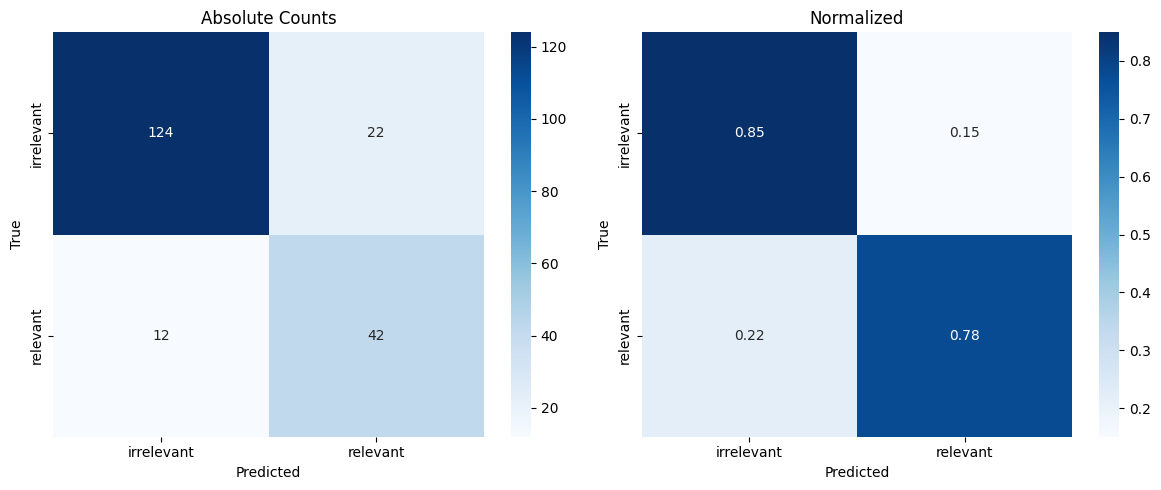

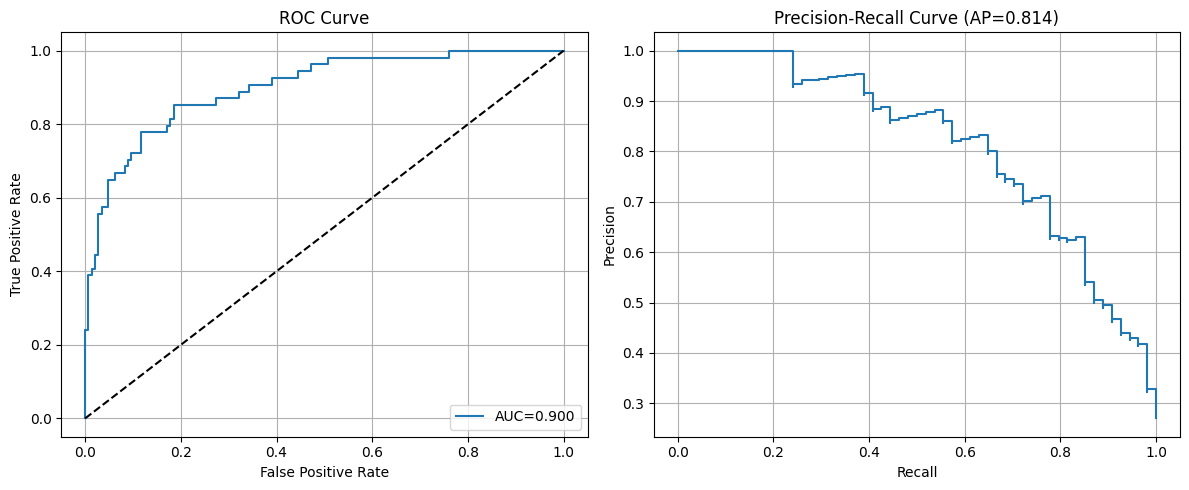


Model saved as model_tfidf_xgb_advanced.joblib


In [ ]:
#perform train-test split on advanced cleaned data
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a XGB classifier 
pipeline_tfidf_xgb = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("clf",     XGBClassifier(
                objective='binary:logistic',
                tree_method='hist',
                n_jobs=-1,  # Use all available CPU cores
                random_state=42,                  
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter grid for gridsearch
param_grid = {
    "clf__learning_rate":    [0.09, 0.10, 0.11],      # peaked ~0.06–0.09; include 0.12 as upward scout
    "clf__n_estimators":     [3800, 3900, 4000],            # ES will pick best iter; covers ~1.3–3.5k compactly
    "clf__scale_pos_weight": [20.0, 25.0, 30.0],        # winners sat ~3.7–8.6; add 12 to probe higher ratio
    "clf__reg_alpha":        [0.1, 0.40, 0.70],            # two regimes seen: small (~0.01–0.1) vs mid (~0.3–0.5)
    "select__k":             [90, 120, 150],          # best rows clustered ~90–200; keep search tight

    # fixed (low importance) to shrink grid:
    "clf__max_depth":        [4],                     # low importance; top rows often depth=4
    "clf__gamma":            [2.0],                   # low importance; mid of 1–4 band from TPE
    "clf__colsample_bytree": [0.30],                  # low importance; near your top-1 (≈0.28–0.33)
    "phrases__enable":       [False],                 # phrases hurt/neutral here; drop extra knobs
}

model_name = "tfidf_xgb_advanced"

#for second search with grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_tfidf_xgb,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")
